In [1]:
import argparse
import os
import pickle
import json
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import torch
from torch.nn import CrossEntropyLoss
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm

import math
import matplotlib.pyplot as plt
from pprint import pprint
import plotly.graph_objs as go
import plotly.express as px

from watermarks.kgw.watermark_processor import WatermarkDetector
from watermarks.aar.aar_watermark import AarWatermarkDetector
from watermarks.watermark_types import WatermarkType
from matplotlib import font_manager

fontP = font_manager.FontProperties()
fontP.set_family('SimHei')
fontP.set_size(14)

DEFAULT_PAD_TOKEN = "[PAD]"
DEFAULT_EOS_TOKEN = "</s>"
DEFAULT_BOS_TOKEN = "<s>"
DEFAULT_UNK_TOKEN = "<unk>"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
# os.environ["CUDA_VISIBLE_DEVICES"]= "1,2,3"


from collections import defaultdict
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import json
import seaborn as sns


/remote-home1/miintern1/anaconda3/envs/watermark/lib/python3.12/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845206/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Using device: cpu


### Heat Map Test (For orthogonality)

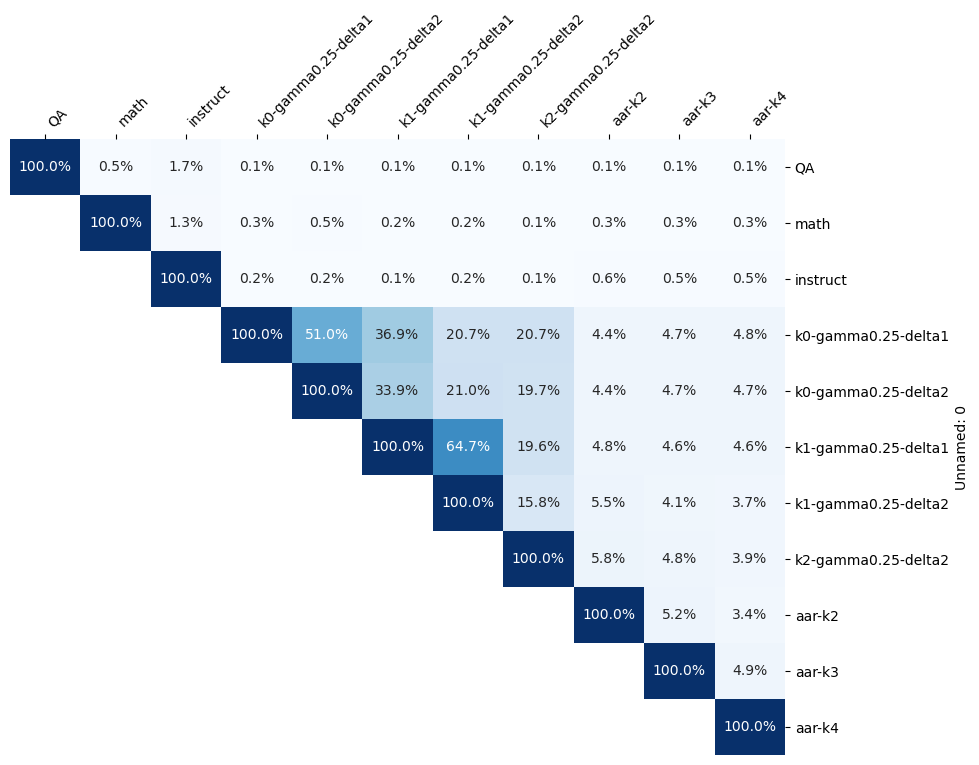

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Set the 'Unnamed: 0' column as the index
df = pd.read_csv('/remote-home1/miintern1/watermark-learnability/experiments/task_vector_orthonality_analysis.csv')
df.set_index('Unnamed: 0', inplace=True)

diagonal_elements = np.sqrt(np.diag(df.values))
normalized_df = df.copy()

for i in range(len(diagonal_elements)):
    normalized_df.iloc[i, :] = normalized_df.iloc[i, :] / diagonal_elements[i]
    normalized_df.iloc[:, i] = normalized_df.iloc[:, i] / diagonal_elements[i]

# Create a mask for the lower triangular part of the matrix
mask = np.triu(np.ones_like(normalized_df, dtype=bool))

percentage_df = 100 * normalized_df
annot = percentage_df.round(1).astype(str) + '%'

# Create a heatmap with Seaborn
plt.figure(figsize=(10, 8))  # Optional: Control the figure size
# ax = sns.heatmap(normalized_df, annot=True, cmap='Blues', fmt=".1f", cbar=False,  mask=~mask, )
ax = sns.heatmap(percentage_df, annot=annot, cmap='Blues', fmt="", cbar=False, mask=~mask)

# Move x-axis labels to the top
ax.xaxis.set_ticks_position('top')  # Move ticks to the top
ax.xaxis.set_label_position('top')  # Move label position to the top
plt.xticks(rotation=45, ha='left')  # Rotate x-axis labels

# Move y-axis labels to the right
ax.yaxis.tick_right()  # Move ticks to the right side
ax.yaxis.set_label_position('right')  # Move label position to the right
plt.yticks(rotation=0)  # Rotate y-axis labels

# Show the heatmap

plt.savefig("/remote-home1/miintern1/watermark-learnability/data/Figures/task_vector_orthogonality.pdf", format='pdf', bbox_inches='tight')
plt.show()


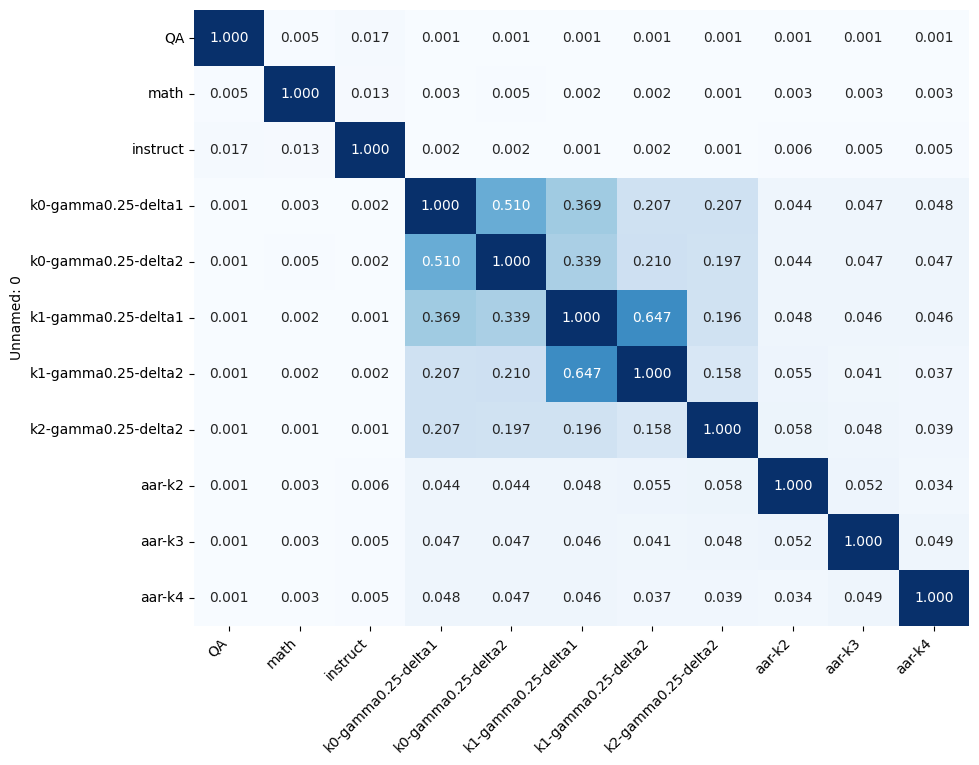

In [187]:
# Set the 'Unnamed: 0' column as the index
df = pd.read_csv('/remote-home1/miintern1/watermark-learnability/experiments/task_vector_orthonality_analysis.csv')
df.set_index('Unnamed: 0', inplace=True)

diagonal_elements = np.sqrt(np.diag(df.values))
normalized_df = df.copy()

for i in range(len(diagonal_elements)):
    normalized_df.iloc[i, :] = normalized_df.iloc[i, :] / diagonal_elements[i]
    normalized_df.iloc[:, i] = normalized_df.iloc[:, i] / diagonal_elements[i]

# Create a heatmap with Seaborn
plt.figure(figsize=(10, 8))  # Optional: Control the figure size
sns.heatmap(normalized_df, annot=True, cmap='Blues', fmt=".3f", cbar = False)
plt.xticks(rotation=45, ha='right')  # Rotate labels by 45 degrees, align right

# normalized_df.to_csv("normalized_task_vector_orthonality_analysis.csv")

# Show the heatmap
# plt.title('Heatmap of the DataFrame')
# plt.tight_layout()
plt.show()

In [253]:
import os
os.environ['http_proxy'] = "http://10.176.52.116:7890"
os.environ['https_proxy'] = "http://10.176.52.116:7890"
os.environ['all_proxy'] = "socks5://10.176.52.116:7891"
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-hf')
# os.getenv('http_proxy')

SSLError: (MaxRetryError("HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /meta-llama/Llama-2-7b-hf/resolve/main/tokenizer_config.json (Caused by SSLError(SSLEOFError(8, '[SSL: UNEXPECTED_EOF_WHILE_READING] EOF occurred in violation of protocol (_ssl.c:1000)')))"), '(Request ID: eb25797c-01ca-4cac-b31f-91ac31d478da)')

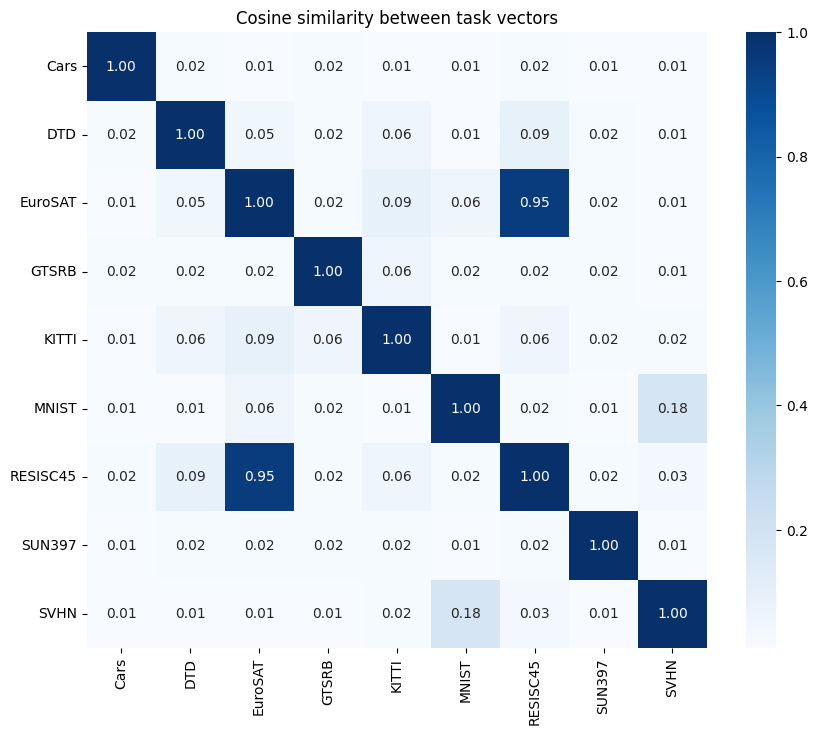

In [77]:
import seaborn as sns
import pandas as pd
# Example data (you should replace this with your actual cosine similarity matrix)
data = np.array([
    [1.00, 0.02, 0.01, 0.02, 0.01, 0.01, 0.02, 0.01, 0.01],
    [0.02, 1.00, 0.05, 0.02, 0.06, 0.01, 0.09, 0.02, 0.01],
    [0.01, 0.05, 1.00, 0.02, 0.09, 0.06, 0.95, 0.02, 0.01],
    [0.02, 0.02, 0.02, 1.00, 0.06, 0.02, 0.02, 0.02, 0.01],
    [0.01, 0.06, 0.09, 0.06, 1.00, 0.01, 0.06, 0.02, 0.02],
    [0.01, 0.01, 0.06, 0.02, 0.01, 1.00, 0.02, 0.01, 0.18],
    [0.02, 0.09, 0.95, 0.02, 0.06, 0.02, 1.00, 0.02, 0.03],
    [0.01, 0.02, 0.02, 0.02, 0.02, 0.01, 0.02, 1.00, 0.01],
    [0.01, 0.01, 0.01, 0.01, 0.02, 0.18, 0.03, 0.01, 1.00],
])

# Labels for the axes
labels = ["Cars", "DTD", "EuroSAT", "GTSRB", "KITTI", "MNIST", "RESISC45", "SUN397", "SVHN"]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add a title
plt.title("Cosine similarity between task vectors")

# Set the tick labels
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Display the plot
plt.show()

In [66]:
with open('/remote-home1/miintern1/watermark-learnability/data/c4/watermark_strength_evaluation_extension.json','r') as f:
    data2 = json.load(f)
with open('/remote-home1/miintern1/watermark-learnability/data/c4/watermark_strength_evaluation.json','r') as f:
    data1 = json.load(f)

data = {}
for watermark_name, watermark_data in data1.items():
    data[watermark_name] = {**watermark_data, **data2[watermark_name]}
    print(data[watermark_name].keys())

dict_keys(['watermark_config', '0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0', '1.3', '1.6', '1.9000000000000001', '2.2', '2.5', '2.8000000000000003', '3.1000000000000005', '3.4000000000000004', '3.7'])
dict_keys(['watermark_config', '0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0', '1.3', '1.6', '1.9000000000000001', '2.2', '2.5', '2.8000000000000003', '3.1000000000000005', '3.4000000000000004', '3.7'])
dict_keys(['watermark_config', '0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0', '1.3', '1.6', '1.9000000000000001', '2.2', '2.5', '2.8000000000000003', '3.1000000000000005', '3.4000000000000004', '3.7'])
dict_keys(['watermark_config', '0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0', '1.3', '1.6'

#### Extract target data for following plotting

In [3]:
with open('/remote-home1/miintern1/watermark-learnability/data/c4/kgw_watermark_vector_chat_llama.json','r') as f:
    data = json.load(f)
pprint(f"There are {data.keys()} watermarks")

x_list = list(data[list(data.keys())[0]].keys())[1:]
label_x_list = [f"{round(float(num), 1):.1f}" for num in x_list]
pprint(f"Coefficient range:{x_list}")
pprint(f"Label range:{label_x_list}")
pprint(f"Attributes:{data[list(data.keys())[0]][x_list[1]].keys()}")

watermarked_score = dict()
vanilla_score = dict()
for model_name, model_data in data.items():
    model_watermarked_scores = []
    model_vanilla_scores = []
    # print(model_data.keys())
    for coefficient, coefficient_data in model_data.items():
        if coefficient == 'watermark_config':
            continue
        watermarked_scores = np.array(coefficient_data['watermarked_scores'])
        vanilla_scores = np.array(coefficient_data['vanilla_scores']) if 'vanilla_scores' in coefficient_data else np.zeros_like(watermarked_scores)
        # print(watermarked_scores.shape)
        watermarked_scores = -np.log(watermarked_scores)
        watermarked_median = np.median(watermarked_scores)
        watermarked_mean = np.mean(watermarked_scores)
        # print(f"{coefficient}: Watermarked median: {watermarked_median}, mean: {watermarked_mean}")
        if 'vanilla_scores' in coefficient_data:
            vanilla_scores = -np.log(vanilla_scores)
            vanilla_median = np.median(vanilla_scores)
            vanilla_mean = np.mean(vanilla_scores)
            model_vanilla_scores.append(vanilla_median)

        model_watermarked_scores.append(watermarked_median)
    watermarked_score[model_name] = model_watermarked_scores
    vanilla_score[model_name] = model_vanilla_scores


('There are '
 "dict_keys(['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1', "
 "'cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2', "
 "'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1', "
 "'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2', "
 "'cygu/llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2']) "
 'watermarks')
("Coefficient range:['0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', "
 "'0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0', '1.3', "
 "'1.6', '1.9000000000000001', '2.2', '2.5', '2.8000000000000003', "
 "'3.1000000000000005', '3.4000000000000004', '3.7']")
("Label range:['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', "
 "'0.9', '1.0', '1.3', '1.6', '1.9', '2.2', '2.5', '2.8', '3.1', '3.4', '3.7']")
("Attributes:dict_keys(['watermarked_output', 'full_watermarked_output', "
 "'vanilla_output', 'vanilla_scores', 'watermarked_scores', "
 "'median_seq_rep_3', 'me

/tmp/ipykernel_454684/96094980.py:23: RuntimeWarning: divide by zero encountered in log
  watermarked_scores = -np.log(watermarked_scores)


In [80]:
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False
coefficient_list = [coefficient for coefficient in data[list(data.keys())[0]].keys() if is_float(coefficient)]
def to_scientific_notation(x):
    number = math.pow(10, -x)
    m, n = f"{number:.2e}".split("e")
    n = int(n)
    return float(m), n
print(coefficient_list)


selected_coefficient = '1.0'
assert selected_coefficient in coefficient_list
selected_indice = coefficient_list.index(selected_coefficient)
print(f"Selected coefficient: {selected_coefficient}, correpsponding index: {selected_indice}")

['0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0', '1.3', '1.6', '1.9000000000000001', '2.2', '2.5', '2.8000000000000003', '3.1000000000000005', '3.4000000000000004', '3.7']
Selected coefficient: 1.0, correpsponding index: 10


### p-values

In [81]:
selected_score_list = []
for watermark, score in watermarked_score.items():
    selected_score_list.append(score[selected_indice])
x = np.average(selected_score_list)
print(f"{x=}")
m, n = to_scientific_notation(x)
print(f"Average p-value::10^{x} = {m} * 10^{n}")

x=0.6809957606415575
Average p-value::10^0.6809957606415575 = 2.08 * 10^-1


In [82]:
auroc_dict = {}
selected_auroc = []

for index, (watermark_name, watermark_data) in enumerate(data.items()):
    # Initialize a single figure object
    auroc_dict[watermark_name] = []
    # Loop through each coefficient and add an ROC curve trace
    for i, coefficient in enumerate(coefficient_list):
        # vanilla_data = aar_data['cygu/llama-2-7b-logit-watermark-distill-aar-k2'][coefficient]['vanilla_scores']    # Because p-value is the probability of the null hypothesis, we need to invert the scores
        # vanilla_data = [1.0 - score for score in vanilla_data]
        # watermark_data = aar_data['cygu/llama-2-7b-logit-watermark-distill-aar-k2'][coefficient]['watermarked_scores']
        # watermark_data = [1.0 - score for score in watermark_data]

        vanilla_data = data[watermark_name][coefficient]['vanilla_scores']    # Because p-value is the probability of the null hypothesis, we need to invert the scores
        vanilla_data = [1.0 - score for score in vanilla_data]
        watermark_data = data[watermark_name][coefficient]['watermarked_scores']
        watermark_data = [1.0 - score for score in watermark_data]

        # Combine the data and create labels
        y_true = np.concatenate([np.zeros(len(vanilla_data)), np.ones(len(watermark_data))])
        y_scores = np.concatenate([vanilla_data, watermark_data])

        # Compute the ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        # Compute the AUROC
        auroc = roc_auc_score(y_true, y_scores)
        auroc_dict[watermark_name].append(auroc)
        # print(f"AUROC for coefficient {coefficient}: {auroc}")
    print(f"Watermark {watermark_name} AUROC: {auroc_dict[watermark_name][selected_indice]}")
    selected_auroc.append(auroc_dict[watermark_name][selected_indice])

print(f"Average AUROC: {np.average(selected_auroc)}")

Watermark cygu/pythia-1.4b-sampling-watermark-distill-aar-k2 AUROC: 0.4953145980834961
Watermark cygu/pythia-1.4b-sampling-watermark-distill-aar-k3 AUROC: 0.4977869987487793
Watermark cygu/pythia-1.4b-sampling-watermark-distill-aar-k4 AUROC: 0.5036110877990723
Average AUROC: 0.4989042282104492


### Perplexity

In [83]:
selected_perplexity = []
for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    print(median_ppl[selected_indice])
    selected_perplexity.append(median_ppl[selected_indice])
    # print(len(median_ppl))
print(f"Average perplexity: {np.mean(selected_perplexity)}")

10.306841850280762
9.175518035888672
8.76385498046875
Average perplexity: 9.41540495554606


### Seq-rep-3

In [84]:
selected_seq_rep_3 = []
for watermark, model_stat in data.items():
    seq_rep = model_stat[selected_coefficient]['median_seq_rep_3']
    selected_seq_rep_3.append(seq_rep)
print(f"Average seq_rep_3: {np.mean(selected_seq_rep_3)}")

Average seq_rep_3: 0.06932388912084342


## For decoding-based result

In [403]:
with open("/remote-home1/miintern1/watermark-learnability/Essay_data/Main_watermark_result/aar_watermark_original_llama_QA.json", "r") as f:
    data = json.load(f)

print(len(data.keys()))

watermark_scores = []
watermark_seq_rep_3 = []
watermark_perplexity = []
for watermark_name, watermark_data in data.items():
    # print(watermark_data.keys())
    watermark_scores.append(np.median(watermark_data['watermarked_scores']))
    # print(len(watermark_data['vanilla_scores']))
    # print(np.median(watermark_data['watermarked_scores']))
    watermark_seq_rep_3.append(watermark_data['mean_seq_rep_3'])
    watermark_perplexity.append(watermark_data['mean_perplexity'])
    # print(f"{watermar}")
    # print(f"{watermark_data['median_seq_rep_3']=}")
    # print(f"{watermark_data['mean_perplexity']=}")

watermark_scores = [-math.log(score) for score in watermark_scores]
x = np.average(watermark_scores)
print(f"{x=}")
m, n = to_scientific_notation(x)
print(f"Average p-value::10^{x} = {m} * 10^{n}")
print(f"Average perplexity: {np.mean(watermark_perplexity)}")
print(f"Average seq_rep_3: {np.mean(watermark_seq_rep_3)}")


auroc_dict = {}
selected_auroc = []

for index, (watermark_name, watermark_data) in enumerate(data.items()):
    # Initialize a single figure object
    auroc_dict[watermark_name] = []
    # Loop through each coefficient and add an ROC curve trace


    vanilla_data = data[watermark_name]['vanilla_scores']    # Because p-value is the probability of the null hypothesis, we need to invert the scores
    vanilla_data = [1.0 - score for score in vanilla_data]
    watermark_data = data[watermark_name]['watermarked_scores']
    watermark_data = [1.0 - score for score in watermark_data]

    # Combine the data and create labels
    y_true = np.concatenate([np.zeros(len(vanilla_data)), np.ones(len(watermark_data))])
    y_scores = np.concatenate([vanilla_data, watermark_data])

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Compute the AUROC
    auroc = roc_auc_score(y_true, y_scores)
    auroc_dict[watermark_name].append(auroc)
    # print(f"AUROC for coefficient {coefficient}: {auroc}")
    # print(f"Watermark {watermark_name} AUROC: {auroc_dict[watermark_name]}")
    selected_auroc.append(auroc_dict[watermark_name])

print(f"Average AUROC: {np.average(selected_auroc)}")

3
x=63.54146734963904
Average p-value::10^63.54146734963904 = 2.87 * 10^-64
Average perplexity: 6.034428020007908
Average seq_rep_3: 0.06021064126074116
Average AUROC: 0.9993235270182291


In [387]:
auroc_dict = {}
selected_auroc = []

for index, (watermark_name, watermark_data) in enumerate(data.items()):
    # Initialize a single figure object
    auroc_dict[watermark_name] = []
    # Loop through each coefficient and add an ROC curve trace


    vanilla_data = data[watermark_name]['vanilla_scores']    # Because p-value is the probability of the null hypothesis, we need to invert the scores
    vanilla_data = [1.0 - score for score in vanilla_data]
    watermark_data = data[watermark_name]['watermarked_scores']
    watermark_data = [1.0 - score for score in watermark_data]

    # Combine the data and create labels
    y_true = np.concatenate([np.zeros(len(vanilla_data)), np.ones(len(watermark_data))])
    y_scores = np.concatenate([vanilla_data, watermark_data])

    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    # Compute the AUROC
    auroc = roc_auc_score(y_true, y_scores)
    auroc_dict[watermark_name].append(auroc)
        # print(f"AUROC for coefficient {coefficient}: {auroc}")
    print(f"Watermark {watermark_name} AUROC: {auroc_dict[watermark_name]}")
    selected_auroc.append(auroc_dict[watermark_name])

print(f"Average AUROC: {np.average(selected_auroc)}")

Watermark cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1 AUROC: [0.9821319580078125]
Watermark cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2 AUROC: [0.9920864105224609]
Watermark cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1 AUROC: [0.9685077667236328]
Watermark cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2 AUROC: [0.9907779693603516]
Watermark cygu/llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2 AUROC: [0.9968776702880859]
Average AUROC: 0.9860763549804688


### Finetuning Ability QA

In [5]:
with open('/remote-home1/miintern1/watermark-learnability/data/finetune_ability/MMLU/full_zero_shot_alpaca_MMLU_accuracy.json', 'r') as f:
    QA_accuracy = json.load(f)
print(QA_accuracy)

MMLU_accuracy = []
MMLU_kgw_accuracy = []
MMLU_aar_accuracy = []
for model, model_data in QA_accuracy.items():
    print(f"{model}: {model_data['weighted_acc']}")
    if model != 'original_model' and model != 'base_model':
        MMLU_accuracy.append(model_data['weighted_acc'])
        if 'kgw' in model:
            MMLU_kgw_accuracy.append(model_data['weighted_acc'])
        elif 'aar' in model:
            MMLU_aar_accuracy.append(model_data['weighted_acc'])
        else:
            MMLU_accuracy.append(model_data['weighted_acc'])

assert len(MMLU_accuracy) == 8
assert len(MMLU_kgw_accuracy) == 5
assert len(MMLU_aar_accuracy) == 3
print(f"Average QA accuracy: {np.mean(MMLU_accuracy)}")

{'cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1': {'abstract_algebra': 0.2, 'anatomy': 0.4222222222222222, 'astronomy': 0.40131578947368424, 'business_ethics': 0.5, 'clinical_knowledge': 0.4716981132075472, 'college_biology': 0.4583333333333333, 'college_chemistry': 0.27, 'college_computer_science': 0.36, 'college_mathematics': 0.34, 'college_medicine': 0.42196531791907516, 'college_physics': 0.21568627450980393, 'computer_security': 0.51, 'conceptual_physics': 0.3872340425531915, 'econometrics': 0.2543859649122807, 'electrical_engineering': 0.4689655172413793, 'elementary_mathematics': 0.25132275132275134, 'formal_logic': 0.29365079365079366, 'global_facts': 0.26, 'high_school_biology': 0.4967741935483871, 'high_school_chemistry': 0.29064039408866993, 'high_school_computer_science': 0.38, 'high_school_european_history': 0.4727272727272727, 'high_school_geography': 0.5707070707070707, 'high_school_government_and_politics': 0.6217616580310881, 'high_school_macroeconomi

### Finetuning Ability Math

In [7]:
with open('/remote-home1/miintern1/watermark-learnability/data/finetune_ability/kgw_math_gsm8k/math_ability_test.json', 'r') as f:
    math_ability = json.load(f)
print(math_ability)

gsm8k_accuracy = []
gsm8k_kgw_accuracy = []
gsm8k_aar_accuracy = []
for watermark_name, accuracy in math_ability['neuralmagic/Llama-2-7b-gsm8k'].items():
    gsm8k_accuracy.append(accuracy)
    if 'kgw' in watermark_name:
        gsm8k_kgw_accuracy.append(accuracy)
    elif 'aar' in watermark_name:
        gsm8k_aar_accuracy.append(accuracy)
    else:
        print(f"Unknown watermark type: {watermark_name}")
assert len(gsm8k_accuracy) == 8
assert len(gsm8k_kgw_accuracy) == 5
assert len(gsm8k_aar_accuracy) == 3
print(f"Average GSM8K accuracy: {np.mean(gsm8k_accuracy)}")

{'neuralmagic/Llama-2-7b-gsm8k': {'cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1': 0.3525, 'cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2': 0.365, 'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1': 0.37, 'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2': 0.365, 'cygu/llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2': 0.3275, 'cygu/llama-2-7b-logit-watermark-distill-aar-k2': 0.365, 'cygu/llama-2-7b-logit-watermark-distill-aar-k3': 0.34, 'cygu/llama-2-7b-logit-watermark-distill-aar-k4': 0.3525}, 'original_model': 0.3775, 'base_model': 0.0}
Average GSM8K accuracy: 0.35468750000000004


In [8]:
# Multiply each element in the lists by 100 to convert to percentages
kgw_accuracy = [100 * np.average(MMLU_kgw_accuracy), 100 * np.average(gsm8k_kgw_accuracy)]
aar_accuracy = [100 * np.average(MMLU_aar_accuracy), 100 * np.average(gsm8k_aar_accuracy)]
original_accuracy = [100 * QA_accuracy['original_model']['weighted_acc'], 100 * math_ability['original_model']]
base_accuracy = [100 * QA_accuracy['base_model']['weighted_acc'], 100 * math_ability['base_model']]
print(kgw_accuracy)
print(aar_accuracy)

full_data = [kgw_accuracy,aar_accuracy]
print(full_data[0])

[43.05796895029198, 35.6]
[42.82865688648341, 35.25]
[43.05796895029198, 35.6]


### Finetuning Ability Plotting

In [9]:
# Multiply each element in the lists by 100 to convert to percentages
kgw_accuracy = [100 * np.average(MMLU_kgw_accuracy), 100 * np.average(gsm8k_kgw_accuracy)]
aar_accuracy = [100 * np.average(MMLU_aar_accuracy), 100 * np.average(gsm8k_aar_accuracy)]
original_accuracy = [100 * QA_accuracy['original_model']['weighted_acc'], 100 * math_ability['original_model']]
base_accuracy = [100 * QA_accuracy['base_model']['weighted_acc'], 100 * math_ability['base_model']]
base_accuracy = [29.68, 18.1 ]
print(kgw_accuracy)
print(aar_accuracy)

full_data = [kgw_accuracy,aar_accuracy]
print(full_data[0])
print(original_accuracy)

[43.05796895029198, 35.6]
[42.82865688648341, 35.25]
[43.05796895029198, 35.6]
[43.61202107961829, 37.75]


In [154]:
plt.rcParams['font.family'] = 'sans-serif'

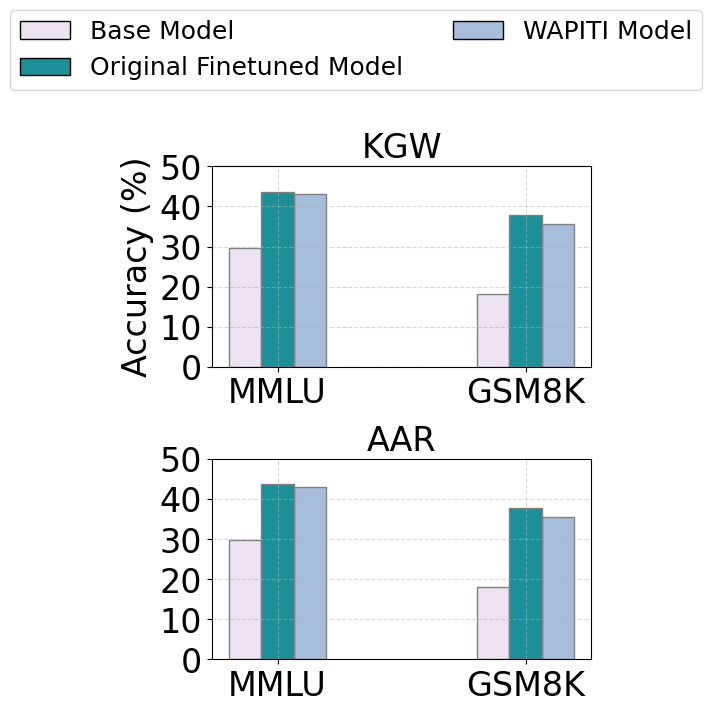

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the Verdana font
verdana_font_path = '/remote-home1/miintern1/watermark-learnability/data/Fonts/VERDANA.TTF'
verdana_font = font_manager.FontProperties(fname=verdana_font_path)

# Create a figure and axis
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 6))

# Define labels and positions
labels = ['MMLU', 'GSM8K']  # Corrected label string
names = ['KGW', 'AAR']
x = range(len(labels))
bar_width = 0.13  # Custom bar width
offsets = [-bar_width, 0, bar_width]  # Three bars need three offsets
ranges = ['Base Model', 'Original Finetuned Model', 'WAPITI Model']
colors = ['#ece2f0','#1c9099','#a6bddb']
watermarked_range = [2,3]

for i, data in enumerate(full_data):
        ax = axes[i]
        ax.bar([pos + offsets[0] for pos in x], height=base_accuracy, width=bar_width,
        color=colors[0], label='Base Model', edgecolor='grey')
        ax.bar([pos + offsets[2] for pos in x], height=kgw_accuracy, width=bar_width,
        color=colors[2], label='Watermarked Finetuned Model', edgecolor='grey')  # yerr=watermarked_range,
        ax.bar([pos + offsets[1] for pos in x], height=original_accuracy, width=bar_width,
        color=colors[1], label='Original Finetuned Model', edgecolor='grey')

        # Set plot details
        ax.set_title(names[i], fontsize=24)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, fontsize=24)

        ax.set_ylim([0,50])
        ax.set_yticks(range(0, 51, 10))
        ax.grid(True, linestyle='--', alpha=0.5) 
        if i == 0:
            ax.set_ylabel('Accuracy (%)', fontsize=24)
        y_ticks = ax.get_yticks()
        ax.set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize=24)
        

legend_elements = [Patch(facecolor=color, label=range_item, edgecolor='black',)
                for color, range_item in zip(colors, ranges)]
fig.legend(handles=legend_elements,
        bbox_to_anchor=(0.5, 1.2),
        loc='upper center',
        fontsize=18, ncol=2)


plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig("/remote-home1/miintern1/watermark-learnability/data/Figures/finetuned_ability_plot.pdf", format="pdf", bbox_inches='tight')

plt.show()

In [193]:
math.log(0.5)/math.log(10)

-0.30102999566398114

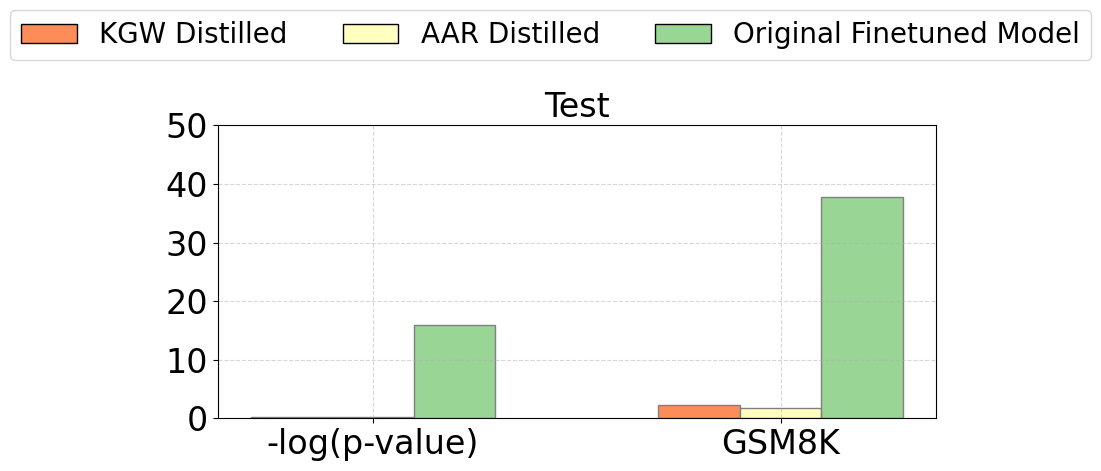

In [201]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Load the Verdana font
# verdana_font_path = '/remote-home1/miintern1/watermark-learnability/data/Fonts/VERDANA.TTF'
# verdana_font = font_manager.FontProperties(fname=verdana_font_path)

# Create a figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))

# Define labels and positions
labels = ['-log(p-value)', 'GSM8K']  # Corrected label string
names = ['', '']
x = range(len(labels))
bar_width = 0.2  # Custom bar width
offsets = [-bar_width, 0, bar_width]  # Three bars need three offsets
ranges = ['KGW Distilled', 'AAR Distilled', 'Original Finetuned Model']
colors = ['#ece2f0','#a6bddb','#1c9099']
watermarked_range = [2,3]

kgw_results = [0.3, 2.3]
aar_results = [0.28, 1.8]
original_results = [16, 37.75]


ax.bar([pos + offsets[0] for pos in x], height=kgw_results, width=bar_width,
color=colors[0], label='KGW Distilled', edgecolor='grey')
ax.bar([pos + offsets[1] for pos in x], height=aar_results, width=bar_width,
color=colors[1], label='AAR Distilled', edgecolor='grey')  # yerr=watermarked_range,
ax.bar([pos + offsets[2] for pos in x], height=original_results, width=bar_width,
color=colors[2], label='Original Finetuned Model', edgecolor='grey')

# Set plot details
ax.set_title("Test", fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=24)

ax.set_ylim([0,50])
ax.set_yticks(range(0, 51, 10))
ax.grid(True, linestyle='--', alpha=0.5) 
if i == 0:
    ax.set_ylabel('Accuracy (%)', fontsize=24)
y_ticks = ax.get_yticks()
ax.set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize=24)


legend_elements = [Patch(facecolor=color, label=range_item, edgecolor='black',)
                for color, range_item in zip(colors, ranges)]
fig.legend(handles=legend_elements,
        bbox_to_anchor=(0.5, 1.20),
        loc='upper center',
        fontsize=20, ncol=3)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

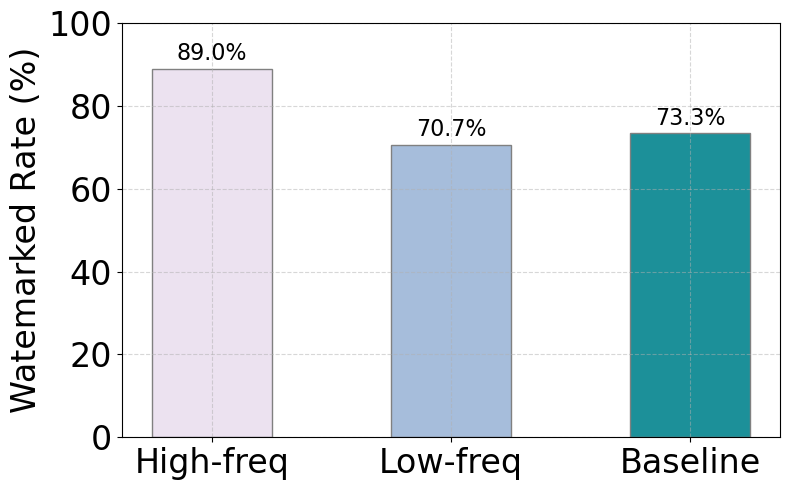

In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create a figure and axis
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

# Define labels and positions
labels = ['High-freq', 'Low-freq', 'Baseline']
x = range(len(labels))

# Compute the values as percentages
values = [267 / 300 * 100, 212 / 300 * 100, 220 / 300 * 100]

# Define colors for each bar
colors = ['#ece2f0','#a6bddb','#1c9099'] # Example colors

# Plot the bars
bar_width = 0.5  # Adjusted bar width
ax.bar(x, height=values, width=bar_width, color=colors, edgecolor='grey')

# Set plot details
# ax.set_title("Test", fontsize=24)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=24)  # Rotate labels if they are long
ax.set_ylim([0, 100])
ax.set_yticks(range(0, 101, 20))
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_ylabel('Watemarked Rate (%)', fontsize=24)
y_ticks = ax.get_yticks()
ax.set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize=24)

# Optionally, add data labels on top of each bar
for i, value in enumerate(values):
    ax.text(i, value + 2, f"{value:.1f}%", ha='center', fontsize=16)

# Remove legend if not necessary
# If you want to keep the legend, uncomment the following lines:
# legend_elements = [Patch(facecolor=color, label=label, edgecolor='black') for color, label in zip(colors, labels)]
# fig.legend(handles=legend_elements, bbox_to_anchor=(0.5, 1.10), loc='upper center', fontsize=12, ncol=3)

plt.tight_layout()
plt.savefig("/remote-home1/miintern1/watermark-learnability/data/Figures/ngram_distillation_watermarked_rate.pdf", format="pdf", bbox_inches='tight')
plt.show()


### Fintuning defense result

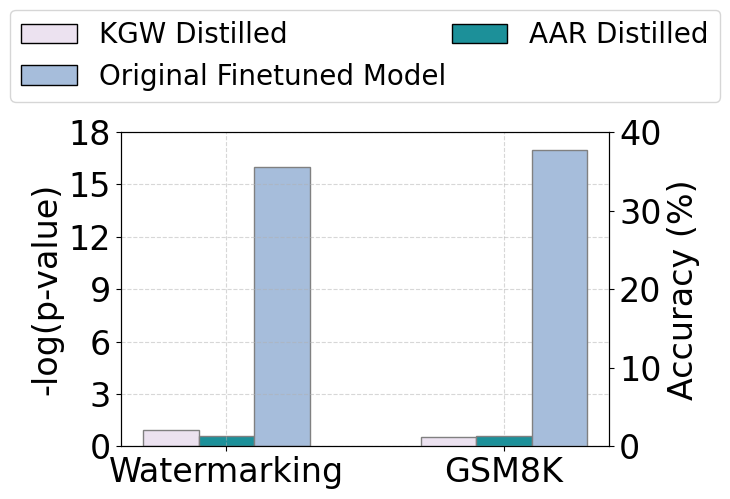

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create a figure and axis
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))

# Define labels and positions
labels = ['Watermarking', 'GSM8K']  # Corrected label string
x = range(len(labels))
bar_width = 0.2  # Custom bar width
offsets = [-bar_width, 0, bar_width]  # Three bars need three offsets
ranges = ['KGW Distilled', 'Original Finetuned Model', 'AAR Distilled']
colors = ['#ece2f0','#a6bddb','#1c9099']

# Data for bars
kgw_results = [0.92, 1.2]
aar_results = [0.60, 1.3]
original_results = [16, 37.75]

# Plot the first values (for -log()) on ax1
ax1.bar([pos + offsets[0] for pos in [0]], height=[kgw_results[0]], width=bar_width,
        color=colors[0], label='KGW Distilled', edgecolor='grey')
ax1.bar([pos + offsets[1] for pos in [0]], height=[aar_results[0]], width=bar_width,
        color=colors[2], label='AAR Distilled', edgecolor='grey')
ax1.bar([pos + offsets[2] for pos in [0]], height=[original_results[0]], width=bar_width,
        color=colors[1], label='Original Finetuned Model', edgecolor='grey')

# Left y-axis for -log() values
ax1.set_ylabel('-log(p-value)', fontsize=24)
ax1.set_ylim([0, 18])
ax1.set_yticks(range(0, 19, 3))
ax1.tick_params(axis='y', labelsize=24)

# Create a second y-axis for Accuracy (%) values
ax2 = ax1.twinx()

# Plot the second values (for Accuracy %) on ax2
ax2.bar([pos + offsets[0] for pos in [1]], height=[kgw_results[1]], width=bar_width,
        color=colors[0], edgecolor='grey')
ax2.bar([pos + offsets[1] for pos in [1]], height=[aar_results[1]], width=bar_width,
        color=colors[2], edgecolor='grey')
ax2.bar([pos + offsets[2] for pos in [1]], height=[original_results[1]], width=bar_width,
        color=colors[1], edgecolor='grey')

# Right y-axis for Accuracy (%) values
ax2.set_ylabel('Accuracy (%)', fontsize=24)
ax2.set_ylim([0, 40])
ax2.set_yticks(range(0, 41, 10))
ax2.tick_params(axis='y', labelsize=24)

# Set the title and x-axis labels
# ax1.set_title("Test", fontsize=24)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=24)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.5)

# Legend
legend_elements = [Patch(facecolor=color, label=range_item, edgecolor='black')
                   for color, range_item in zip(colors, ranges)]
fig.legend(handles=legend_elements,
           bbox_to_anchor=(0.5, 1.27),
           loc='upper center',
           fontsize=20, 
           ncol=2,
            columnspacing=0.2)

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig("/remote-home1/miintern1/watermark-learnability/data/Figures/finetuning_attack_result.pdf", format="pdf", bbox_inches='tight')
plt.show()


### GSM8k finetune reulst

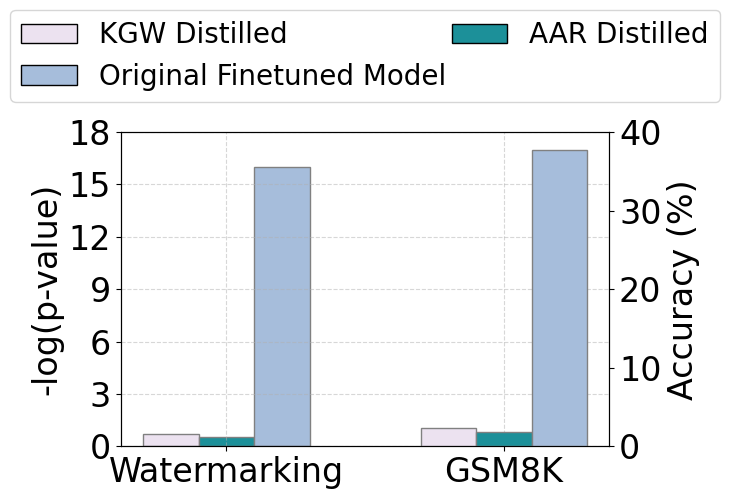

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Create a figure and axis
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))

# Define labels and positions
labels = ['Watermarking', 'GSM8K']  # Corrected label string
x = range(len(labels))
bar_width = 0.2  # Custom bar width
offsets = [-bar_width, 0, bar_width]  # Three bars need three offsets
ranges = ['KGW Distilled', 'Original Finetuned Model', 'AAR Distilled']
colors = ['#ece2f0','#a6bddb','#1c9099']

# Data for bars
kgw_results = [0.69, 2.3]
aar_results = [0.51, 1.8]
original_results = [16, 37.75]

# Plot the first values (for -log()) on ax1
ax1.bar([pos + offsets[0] for pos in [0]], height=[kgw_results[0]], width=bar_width,
        color=colors[0], label='KGW Distilled', edgecolor='grey')
ax1.bar([pos + offsets[1] for pos in [0]], height=[aar_results[0]], width=bar_width,
        color=colors[2], label='AAR Distilled', edgecolor='grey')
ax1.bar([pos + offsets[2] for pos in [0]], height=[original_results[0]], width=bar_width,
        color=colors[1], label='Original Finetuned Model', edgecolor='grey')

# Left y-axis for -log() values
ax1.set_ylabel('-log(p-value)', fontsize=24)
ax1.set_ylim([0, 18])
ax1.set_yticks(range(0, 19, 3))
ax1.tick_params(axis='y', labelsize=24)

# Create a second y-axis for Accuracy (%) values
ax2 = ax1.twinx()

# Plot the second values (for Accuracy %) on ax2
ax2.bar([pos + offsets[0] for pos in [1]], height=[kgw_results[1]], width=bar_width,
        color=colors[0], edgecolor='grey')
ax2.bar([pos + offsets[1] for pos in [1]], height=[aar_results[1]], width=bar_width,
        color=colors[2], edgecolor='grey')
ax2.bar([pos + offsets[2] for pos in [1]], height=[original_results[1]], width=bar_width,
        color=colors[1], edgecolor='grey')

# Right y-axis for Accuracy (%) values
ax2.set_ylabel('Accuracy (%)', fontsize=24)
ax2.set_ylim([0, 40])
ax2.set_yticks(range(0, 41, 10))
ax2.tick_params(axis='y', labelsize=24)

# Set the title and x-axis labels
# ax1.set_title("Test", fontsize=24)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=24)

# Add grid
ax1.grid(True, linestyle='--', alpha=0.5)

# Legend
legend_elements = [Patch(facecolor=color, label=range_item, edgecolor='black')
                   for color, range_item in zip(colors, ranges)]
fig.legend(handles=legend_elements,
           bbox_to_anchor=(0.5, 1.27),
           loc='upper center',
           fontsize=20, 
           ncol=2,
            columnspacing=0.2)

# Adjust layout and show the plot
plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.savefig("/remote-home1/miintern1/watermark-learnability/data/Figures/watermark_finetuning_result.pdf", format="pdf", bbox_inches='tight')
plt.show()


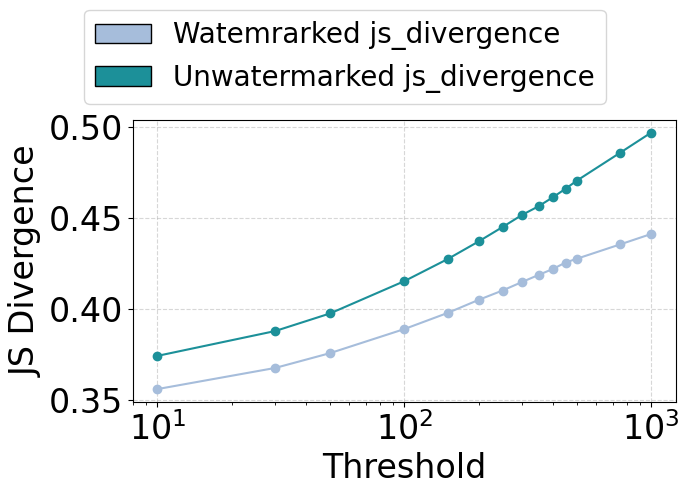

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# Define data
colors = ['#a6bddb','#1c9099']
threshold = [1000, 750, 500, 450, 400, 350, 300, 250, 200, 150, 100, 50, 30, 10]
watermarked_js_divergence = [0.4412184031454967, 0.4355116325004167, 0.427576862808762, 0.4254841748958317, 
                             0.4219400588761706, 0.41865476386575046, 0.41476234094278525, 0.4100639145158974, 
                             0.40489525379327246, 0.3977300027559137, 0.3888076149645468, 0.3755401765157478, 
                             0.3673969603275233, 0.35574418372375544]
unwatermarked_js_divergence = [0.49709065836320276, 0.48604285435725864, 0.47061136764075434, 0.46612624773698896, 
                               0.46145617173708353, 0.45649834201569556, 0.4517222348250231, 0.4450263416942614, 
                               0.43708475488033216, 0.4274116069112314, 0.4152060657039733, 0.3974085460033148, 
                               0.3877338361255535, 0.3740381078803043]

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(7, 4))

# Plot watermarked and unwatermarked js_divergence
ax1.plot(threshold, watermarked_js_divergence, label='Watermarked js_divergence', color=colors[0], marker='o')
ax1.plot(threshold, unwatermarked_js_divergence, label='Unwatermarked js_divergence', color=colors[1], marker='o')

# Set x-axis to log scale
ax1.set_xscale('log')

# Set labels
ax1.set_ylabel('JS Divergence', fontsize=24)
ax1.set_xlabel('Threshold', fontsize=24)

ax1.tick_params(axis='both', which='major', labelsize=24)  # Adjust 'labelsize' to desired font size
# Add grid
ax1.grid(True, linestyle='--', alpha=0.5)

# Add legend
ranges = ['Watemrarked js_divergence', 'Unwatermarked js_divergence']
# ax1.legend(loc='upper right', fontsize=12)
legend_elements = [Patch(facecolor=color, label=range_item, edgecolor='black')
                   for color, range_item in zip(colors, ranges)]

fig.legend(handles=legend_elements,
           bbox_to_anchor=(0.5, 1.26),
           loc='upper center',
           fontsize=20, 
           ncol=1,
            columnspacing=0.2)
# Set title
# ax1.set_title('Watermarked vs Unwatermarked JS Divergence', fontsize=16)

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("/remote-home1/miintern1/watermark-learnability/data/Figures/js_divergence.pdf", format="pdf", bbox_inches='tight')
plt.show()


### AUROC Plotting

In [26]:
from collections import defaultdict
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import json


In [22]:
# with open('/remote-home/miintern1/watermark-learnability/data/c4/watermark_vector_evaluation_extension.json', 'r') as f:
#     kgw_data_extension = json.load(f)

save_name = "instruct_pythia"
watermark_name = "AAR"
if 'pythia' in save_name:
    offset = 44
elif 'llama' in save_name:
    offset = 40
else:
    print("Unknown watermark name")

if watermark_name == "KGW":
    legend_y_position = 0.95   
elif watermark_name == "AAR":
    legend_y_position = 1.10
else:
    print("Unknown watermark name")

with open('/remote-home1/miintern1/watermark-learnability/data/c4/aar_watermark_vector_instruct_pythia-1.4b.json','r') as f:
    data = json.load(f)
pprint(f"There are {data.keys()} watermarks")

x_list = list(data[list(data.keys())[0]].keys())[1:]
label_x_list = [f"{round(float(num), 1):.1f}" for num in x_list]
pprint(f"Coefficient range:{x_list}")
pprint(f"Label range:{label_x_list}")
pprint(f"Attributes:{data[list(data.keys())[0]][x_list[1]].keys()}")

watermarked_score = dict()
vanilla_score = dict()
for model_name, model_data in data.items():
    model_watermarked_scores = []
    model_vanilla_scores = []
    # print(model_data.keys())
    for coefficient, coefficient_data in model_data.items():
        if coefficient == 'watermark_config':
            continue
        watermarked_scores = np.array(coefficient_data['watermarked_scores'])
        vanilla_scores = np.array(coefficient_data['vanilla_scores']) if 'vanilla_scores' in coefficient_data else np.zeros_like(watermarked_scores)
        # print(watermarked_scores.shape)
        watermarked_scores = -np.log(watermarked_scores)
        watermarked_median = np.median(watermarked_scores)
        watermarked_mean = np.mean(watermarked_scores)
        # print(f"{coefficient}: Watermarked median: {watermarked_median}, mean: {watermarked_mean}")
        if 'vanilla_scores' in coefficient_data:
            vanilla_scores = -np.log(vanilla_scores)
            vanilla_median = np.median(vanilla_scores)
            vanilla_mean = np.mean(vanilla_scores)
            model_vanilla_scores.append(vanilla_median)

        model_watermarked_scores.append(watermarked_median)
    watermarked_score[model_name] = model_watermarked_scores
    vanilla_score[model_name] = model_vanilla_scores

# print(kgw_data['cygu/pythia-1.4b-sampling-watermark-distill-kgw-k0-gamma0.25-delta1'].keys())
# print(kgw_data_extension['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1']['1.3'].keys())
# combined_data = dict()
# for key in kgw_data.keys():
#     print(key)
#     combined_data[key] = {**kgw_data[key], **kgw_data_extension[key]}
#     print(combined_data[key].keys())

("There are dict_keys(['cygu/pythia-1.4b-sampling-watermark-distill-aar-k2', "
 "'cygu/pythia-1.4b-sampling-watermark-distill-aar-k3', "
 "'cygu/pythia-1.4b-sampling-watermark-distill-aar-k4']) watermarks")
("Coefficient range:['0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', "
 "'0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0', '1.3', "
 "'1.6', '1.9000000000000001', '2.2', '2.5', '2.8000000000000003', "
 "'3.1000000000000005', '3.4000000000000004', '3.7']")
("Label range:['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', "
 "'0.9', '1.0', '1.3', '1.6', '1.9', '2.2', '2.5', '2.8', '3.1', '3.4', '3.7']")
("Attributes:dict_keys(['watermarked_output', 'full_watermarked_output', "
 "'vanilla_output', 'vanilla_scores', 'watermarked_scores', "
 "'median_seq_rep_3', 'mean_seq_rep_3', 'list_seq_rep_3', 'total_rep_3', "
 "'mean_perplexity', 'median_perplexity', 'perplexities'])")


#### For KGW coefficient analysis

['0.1', '0.4', '0.7', '1.0', '1.9', '2.8', '3.7']
['0.1', '0.4', '0.7', '1.0', '1.9', '2.8', '3.7']
[2.0, 9.6, 17.2, 24.8, 32.4, 40.0]


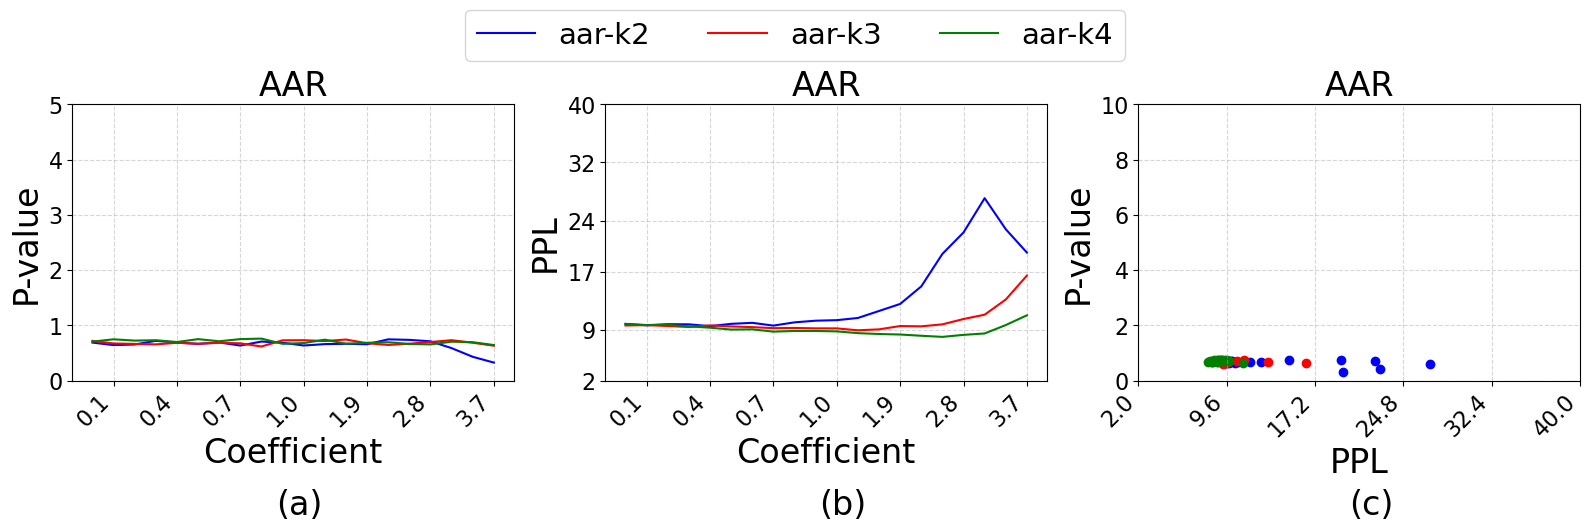

In [26]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# Set up font properties
simhei_font = fm.FontProperties(fname='/remote-home/miintern1/watermark-learnability/SimHei.ttf', size=14)

# Define color list
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
label_fontsize = 24
tick_fontsize = 16
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))


max_p_value = 5
# Plot 1: Watermarked Vector median score vs. Coefficient(Full)
for i, (model, model_stat) in enumerate(watermarked_score.items()):
    x = label_x_list[:len(model_stat)]
    axes[0].plot(x, model_stat, label=f'{model[offset:]}', color=color_list[i])
xticks = x[1::3]
print(xticks)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticks, rotation=45, ha='right',  fontsize = tick_fontsize)  # Rotate for better readability
y_ticks = [int(y) for y in np.linspace(0, max_p_value, 6)]
axes[0].set_ylim([0,max_p_value])
axes[0].set_yticks(y_ticks)
axes[0].set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize= tick_fontsize)

axes[0].set_title(watermark_name, fontsize = label_fontsize)
axes[0].set_xlabel('Coefficient' , fontsize = label_fontsize)
axes[0].set_ylabel('P-value', fontsize = label_fontsize)
axes[0].grid(True, which="both", linestyle="--", alpha = 0.5)

# Plot 2: Median PPL Plot for Watermark Vector(Full)


min_ppl = 2
max_ppl = 40
for i, (model, model_stat) in enumerate(data.items()):
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    axes[1].plot(label_x_list, median_ppl, label=f'{model[offset:]}', color=color_list[i])
xticks = x[1::3]
print(xticks)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticks, rotation=45, ha='right',  fontsize = tick_fontsize)  # Rotate for better readability
y_ticks = [int(y) for y in np.linspace(min_ppl, max_ppl, 6)]
axes[1].set_ylim([min_ppl, max_ppl])
axes[1].set_yticks(y_ticks)
axes[1].set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize= tick_fontsize)

axes[1].set_title(watermark_name, fontsize = label_fontsize)
axes[1].set_xlabel('Coefficient' , fontsize = label_fontsize)
axes[1].set_ylabel('PPL', fontsize = label_fontsize)
axes[1].grid(True, which="both", linestyle="--", alpha = 0.5)

# Plot 3: Watermark Vector Performance(Full)
max_scatter_p_value = 10
for i, (model, model_stat) in enumerate(data.items()):
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    median_watermark_score = [np.median(-np.log(model_stat[str(x)]['watermarked_scores'])) for x in x_list]
    axes[2].scatter(median_ppl, median_watermark_score, label=f'{model[offset:]}', color=color_list[i])
xticks = [round(x,1) for x in np.linspace(min_ppl, max_ppl, 6)]
print(xticks)
axes[2].set_xlim([min_ppl, max_ppl])
axes[2].set_xticks(xticks)
axes[2].set_xticklabels(xticks, rotation=45, ha='right',  fontsize = tick_fontsize)  # Rotate for better readability
y_ticks = [int(y) for y in np.linspace(0, max_scatter_p_value, 6)]
axes[2].set_ylim([0,max_scatter_p_value])
axes[2].set_yticks(y_ticks)
axes[2].set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize= tick_fontsize)

axes[2].set_title(watermark_name, fontsize = label_fontsize)
axes[2].set_xlabel('PPL' , fontsize = label_fontsize)
axes[2].set_ylabel('P-value', fontsize = label_fontsize)
axes[2].grid(True, which="both", linestyle="--", alpha = 0.5)

# Collect legend handles from the first plot (all plots share the same labels)
handles, labels = axes[0].get_legend_handles_labels()

# Create a central legend above the subplots
fig.legend(handles=handles,
           bbox_to_anchor=(0.5, 1.25),
           loc='upper center',
           fontsize=21, ncol=3)


fig.text(0.19, -0.05, '(a)', ha='center', fontsize=label_fontsize)
fig.text(0.53, -0.05, '(b)', ha='center', fontsize=label_fontsize)
fig.text(0.86, -0.05, '(c)', ha='center', fontsize=label_fontsize)

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, legend_y_position])
plt.savefig(f"/remote-home1/miintern1/watermark-learnability/data/Figures/{watermark_name}_{save_name}_coefficient_analysis.pdf", format='pdf', bbox_inches='tight')
plt.show()


#### For AAR coefficient analysis

['0.1', '0.4', '0.7', '1.0', '1.9', '2.8', '3.7']
['0.1', '0.4', '0.7', '1.0', '1.9', '2.8', '3.7']
range(5, 21, 3)


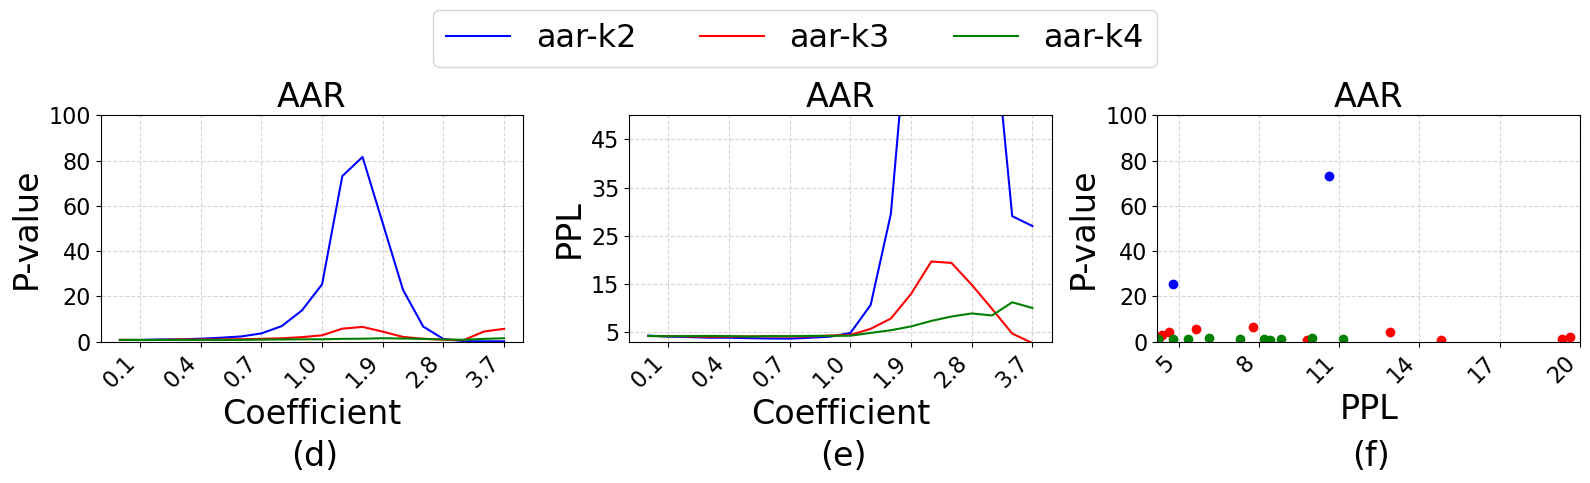

In [120]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

# Set up font properties
simhei_font = fm.FontProperties(fname='/remote-home/miintern1/watermark-learnability/SimHei.ttf', size=14)

# Define color list
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
label_fontsize = 24
tick_fontsize = 16
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Plot 1: Watermarked Vector median score vs. Coefficient(Full)
for i, (model, model_stat) in enumerate(watermarked_score.items()):
    x = label_x_list[:len(model_stat)]
    axes[0].plot(x, model_stat, label=f'{model[40:]}', color=color_list[i])
xticks = x[1::3]
print(xticks)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xticks, rotation=45, ha='right',  fontsize = tick_fontsize)  # Rotate for better readability
y_ticks = range(0, 101, 20)
axes[0].set_ylim([0,100])
axes[0].set_yticks(y_ticks)
axes[0].set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize= tick_fontsize)

axes[0].set_title('AAR', fontsize = label_fontsize)
axes[0].set_xlabel('Coefficient' , fontsize = label_fontsize)
axes[0].set_ylabel('P-value', fontsize = label_fontsize)
axes[0].grid(True, which="both", linestyle="--", alpha = 0.5)

# Plot 2: Median PPL Plot for Watermark Vector(Full)
for i, (model, model_stat) in enumerate(data.items()):
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    axes[1].plot(label_x_list, median_ppl, label=f'{model[40:]}', color=color_list[i])
xticks = x[1::3]
print(xticks)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xticks, rotation=45, ha='right',  fontsize = tick_fontsize)  # Rotate for better readability
y_ticks = range(5, 51, 10)
axes[1].set_ylim([3,50])
axes[1].set_yticks(y_ticks)
axes[1].set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize= tick_fontsize)

axes[1].set_title('AAR', fontsize = label_fontsize)
axes[1].set_xlabel('Coefficient' , fontsize = label_fontsize)
axes[1].set_ylabel('PPL', fontsize = label_fontsize)
axes[1].grid(True, which="both", linestyle="--", alpha = 0.5)

# Plot 3: Watermark Vector Performance(Full)
for i, (model, model_stat) in enumerate(data.items()):
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    median_watermark_score = [np.median(-np.log(model_stat[str(x)]['watermarked_scores'])) for x in x_list]
    axes[2].scatter(median_ppl, median_watermark_score, label=f'{model[40:]}', color=color_list[i])
xticks = range(5,21,3)
print(xticks)
axes[2].set_xlim([4.2,20])
axes[2].set_xticks(xticks)
axes[2].set_xticklabels(xticks, rotation=45, ha='right',  fontsize = tick_fontsize)  # Rotate for better readability
y_ticks = range(0, 101, 20)
axes[2].set_ylim([0, 100])
axes[2].set_yticks(y_ticks)
axes[2].set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize= tick_fontsize)

axes[2].set_title('AAR', fontsize = label_fontsize)
axes[2].set_xlabel('PPL' , fontsize = label_fontsize)
axes[2].set_ylabel('P-value', fontsize = label_fontsize)
axes[2].grid(True, which="both", linestyle="--", alpha = 0.5)

# Collect legend handles from the first plot (all plots share the same labels)
handles, labels = axes[0].get_legend_handles_labels()

# Create a central legend above the subplots
fig.legend(handles=handles,
           bbox_to_anchor=(0.5, 1.13),
           loc='upper center',
           fontsize=23, ncol=3)

# Adjust layout to avoid overlap

fig.text(0.20, -0.05, '(d)', ha='center', fontsize=label_fontsize)
fig.text(0.53, -0.05, '(e)', ha='center', fontsize=label_fontsize)
fig.text(0.86, -0.05, '(f)', ha='center', fontsize=label_fontsize)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("/remote-home1/miintern1/watermark-learnability/data/Figures/AAR_coefficient_analysis.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [ ]:
        ax.set_ylim([0,50])
        ax.set_yticks(range(0, 51, 10))
        ax.grid(True, linestyle='--', alpha=0.5) 
        if i == 0:
            ax.set_ylabel('Accuracy (%)', fontsize=24)
        y_ticks = ax.get_yticks()
        ax.set_yticklabels([f"{int(tick)}" for tick in y_ticks], fontsize=24)

In [34]:
data['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2']['1.0'].keys()
target_data = data['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2']['1.0']['watermarked_output']
print(target_data[0])
vanilla_data = data['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2']['1.0']['vanilla_output']

-tested cluster of servers, storage devices and systems management software that can run both Linux and Windows operating systems.
The Cluster 325, comprising IBM's Opteron-based eServer 325 servers, can be used in a variety of applications, including databases, big data analytics, high-performance computing (HPC), and web applications.
"Our clients are looking for a more efficient way to scale and manage their applications, and a clustered architecture can help them achieve that," said Brendan McGill, global offering manager for IBM's System z and Linux On System z.
The Cluster 325 can be configured with a range of storage devices, including IBM's SAS (Serial Advanced Storage) and SATA (Serial Advanced Technology Attachment) drives, as well as the open source GlusterFS file system.
The system also comes with a range of software tools for managing the


In [13]:
tokenizer = AutoTokenizer.from_pretrained('meta-llama/Llama-2-7b-chat-hf')
watermark_config = {"type": "kgw", "k": 0, "gamma": 0.25, "delta": 2.0, "seeding_scheme": "simple_0", "kgw_device": "cpu"}
detector = WatermarkDetector(
                            device=watermark_config.get("kgw_device", 'cuda'),
                            tokenizer=tokenizer,
                            vocab=tokenizer.get_vocab().values(),
                            gamma=watermark_config["gamma"],
                            seeding_scheme=watermark_config["seeding_scheme"],
                            normalizers=[],
                        )

In [28]:
print(detector.detect(target_data[1]))
green_token_mask = detector.detect(target_data[1], return_green_token_mask=True)['green_token_mask']
tokens = tokenizer(target_data[1], return_tensors="pt") 
input_ids = tokens['input_ids']
print(green_token_mask)
tokens = tokenizer.convert_ids_to_tokens(input_ids[0], skip_special_tokens=True)[:-1]
print(len(tokens))
assert len(tokens) == len(green_token_mask)

{'num_tokens_scored': 199, 'num_green_tokens': 84, 'green_fraction': 0.4221105527638191, 'z_score': 5.6070367371298975, 'p_value': 3.7209798727626364e-08, 'z_score_at_T': tensor([-0.5774, -0.8165,  0.3333,  1.1547,  1.8074,  2.3570,  2.8368,  2.4495,
         2.1170,  1.8257,  1.5667,  1.3333,  1.1209,  0.9258,  0.7454,  0.5774,
         0.9802,  0.8165,  0.6623,  1.0328,  0.8819,  1.2309,  1.0835,  1.4142,
         1.2702,  1.1323,  1.0000,  0.8729,  1.1793,  1.0541,  1.3480,  1.2247,
         1.1055,  0.9901,  0.8783,  1.1547,  1.0441,  0.9366,  0.8321,  0.7303,
         0.6312,  0.5345,  0.4402,  0.3482,  0.2582,  0.5108,  0.4211,  0.6667,
         0.9073,  1.1431,  1.0510,  0.9608,  1.1896,  1.4142,  1.6348,  1.5430,
         1.7589,  1.6678,  1.8791,  1.7889,  1.7002,  1.6131,  1.5275,  1.4434,
         1.3606,  1.2792,  1.4812,  1.6803,  1.5986,  1.7942,  1.9870,  1.9052,
         2.0948,  2.2819,  2.2000,  2.3842,  2.5660,  2.4841,  2.4034,  2.5820,
         2.7585,  2.9329,  2.

In [38]:
from rich.console import Console
from rich.text import Text

# Initialize the console
console = Console()
index= 2
# Assuming detector and tokenizer are already defined and loaded
# Detect green token mask
watermarked_green_token_mask = detector.detect(target_data[index], return_green_token_mask=True)['green_token_mask']
print(f"The number of green list tokens is :{sum(watermarked_green_token_mask)}")
watermarked_input_ids = tokenizer(target_data[index], return_tensors="pt")['input_ids']
watermarked_tokens = tokenizer.convert_ids_to_tokens(watermarked_input_ids[0], skip_special_tokens=True)[:-1]
assert len(watermarked_tokens) == len(watermarked_green_token_mask), "Token list and green token mask lengths do not match!"

vanilla_green_token_mask = detector.detect(vanilla_data[index], return_green_token_mask=True)['green_token_mask']
print(f"The number of green list tokens is :{sum(vanilla_green_token_mask)}")
vanilla_input_ids = tokenizer(vanilla_data[index], return_tensors="pt")['input_ids']
vanilla_tokens = tokenizer.convert_ids_to_tokens(vanilla_input_ids[0], skip_special_tokens=True)[:-1]
assert len(vanilla_tokens) == len(vanilla_green_token_mask), "Token list and green token mask lengths do not match!"

# Function to print tokens with background colors based on green_token_mask
def print_colored_tokens(tokens, green_token_mask):
    result_text = Text()
    for token, is_green in zip(tokens, green_token_mask):
        if is_green:
            result_text.append(token + " ", style="bold on green")
        else:
            result_text.append(token + " ", style="bold on red")
    console.print(result_text)

# Print tokens with color
print_colored_tokens(watermarked_tokens, watermarked_green_token_mask)

print_colored_tokens(vanilla_tokens, vanilla_green_token_mask)


The number of green list tokens is :100
The number of green list tokens is :49


▁and ▁non prof its ▁all ▁the ▁time . ▁From ▁prom oting ▁tour ism ▁to ▁expand ing ▁en roll ment ▁at ▁a ▁local 
▁college , ▁there ▁are ▁plenty ▁of ▁opportun ities ▁to ▁use ▁your ▁market ing ▁skills ▁in ▁the ▁public ▁sector . 
<0x0A> Use ▁the ▁government ▁jobs ▁section ▁on ▁your ▁favorite ▁job ▁board ▁( like ▁USA J O BS ) ▁to ▁see ▁all ▁the
▁opportun ities ▁available . <0x0A> Or ▁check ▁out ▁the ▁following ▁national ▁organizations ▁for ▁job ▁list ings : 
<0x0A> Public ▁Health ▁Service ▁( P HS ) <0x0A> Note ▁the ▁similar ities ▁with ▁the ▁Private ▁S ector ▁section . 
<0x0A> Local ▁Govern ments ▁( c ities , ▁count ies , ▁towns ) ▁also ▁have ▁jobs ▁in ▁market ing ▁( es pecially 
▁tour ism ▁promotion ). <0x0A> Using ▁the ▁Ch amb ers ▁of ▁Com merce ▁in ▁your ▁area , ▁you ▁can ▁get ▁a ▁list ▁of 
▁these ▁organizations ▁and ▁check ▁their ▁job ▁bo ards . <0x0A> Like ▁the ▁Private ▁S ector ▁section , ▁you ▁can 
▁also ▁seek ▁a ▁ment or ▁or ▁ad visor ▁with ▁experience ▁in ▁the ▁public ▁sector ▁to ▁get ▁ins ights ▁on ▁how ▁your
▁skills ▁can ▁be ▁applied . <0x0A> Al umn i ▁from ▁your ▁school ▁( or 

▁at ▁all ▁levels ▁and ▁by ▁non pro fit ▁organizations . <0x0A> At ▁the ▁federal ▁level , ▁the ▁government ▁h ires 
▁market ing ▁profession als ▁to ▁help ▁promote ▁products , ▁services ▁and ▁policies , ▁as ▁well ▁as ▁to ▁coordinate
▁market ing ▁efforts ▁across ▁different ▁ag encies . <0x0A> In ▁local ▁government , ▁mark eters ▁are ▁often ▁task 
ed ▁with ▁prom oting ▁community ▁events , ▁tour ism ▁and ▁economic ▁development ▁initi atives . <0x0A> In ▁non pro 
fit ▁organizations , ▁market ing ▁profession als ▁may ▁be ▁responsible ▁for ▁prom oting ▁social ▁causes , ▁raising 
▁funds , ▁or ▁increasing ▁aw aren ess ▁of ▁an ▁organization ’ s ▁mission ▁and ▁programs . <0x0A> In ▁this ▁blog 
▁post , ▁we ▁will ▁explore ▁the ▁role ▁of ▁market ing ▁in ▁the ▁public ▁sector , ▁the ▁types ▁of ▁jobs ▁available 
▁in ▁this ▁field ▁and ▁the ▁skills ▁and ▁knowledge ▁required ▁for ▁success . <0x0A> Mark eting ▁roles ▁in ▁the 
▁public ▁sector . <0x0A> There ▁are ▁many ▁market ing ▁roles ▁available ▁in ▁the ▁public ▁sector , ▁including : 
<0x0A> 1 . ▁Public ▁relations ▁special ists . <0x0A> 2 . ▁Mark eting ▁anal yst s . <0x0A> 3 . ▁Prom ot ions 
▁coordin ators . <0x0A> 4 . ▁Event ▁pl 

In [28]:
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False
coefficient_list = [coefficient for coefficient in data[list(data.keys())[0]].keys() if is_float(coefficient)]
# with open('/remote-home/miintern1/watermark-learnability/data/c4/aronson_watermark_vector.json', 'r') as f:
#     aar_data = json.load(f)
aar_data = data

# coefficient_list = [coefficient for coefficient in aar_data['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1'].keys() if is_float(coefficient)]

# coefficient_list = [coefficient for coefficient in aar_data['cygu/pythia-1.4b-sampling-watermark-distill-kgw-k0-gamma0.25-delta1'].keys() if is_float(coefficient)]
# coefficient_list = [coefficient for coefficient in aar_data['cygu/llama-2-7b-logit-watermark-distill-aar-k2'].keys() if is_float(coefficient)]
print(coefficient_list)
colormaps = [plt.cm.Reds ,plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges, plt.cm.magma, plt.cm.viridis, plt.cm.inferno, plt.cm.plasma, plt.cm.cividis, plt.cm.spring, plt.cm.summer]

auroc_dict = {}
for index, (watermark_name, watermark_data) in enumerate(aar_data.items()):
    # Initialize a single figure object
    fig = go.Figure()
    color_gradient = colormaps[index]([i/(len(coefficient_list) + 4) for i in range(len(coefficient_list) + 4)])
    colors = [mcolors.rgb2hex(color) for color in color_gradient][4:]
    auroc_dict[watermark_name] = []
    # Loop through each coefficient and add an ROC curve trace
    for i, coefficient in enumerate(coefficient_list):
        # vanilla_data = aar_data['cygu/llama-2-7b-logit-watermark-distill-aar-k2'][coefficient]['vanilla_scores']    # Because p-value is the probability of the null hypothesis, we need to invert the scores
        # vanilla_data = [1.0 - score for score in vanilla_data]
        # watermark_data = aar_data['cygu/llama-2-7b-logit-watermark-distill-aar-k2'][coefficient]['watermarked_scores']
        # watermark_data = [1.0 - score for score in watermark_data]

        vanilla_data = aar_data[watermark_name][coefficient]['vanilla_scores']    # Because p-value is the probability of the null hypothesis, we need to invert the scores
        vanilla_data = [1.0 - score for score in vanilla_data]
        watermark_data = aar_data[watermark_name][coefficient]['watermarked_scores']
        watermark_data = [1.0 - score for score in watermark_data]

        # Combine the data and create labels
        y_true = np.concatenate([np.zeros(len(vanilla_data)), np.ones(len(watermark_data))])
        y_scores = np.concatenate([vanilla_data, watermark_data])

        # Compute the ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_scores)

        # Compute the AUROC
        auroc = roc_auc_score(y_true, y_scores)
        auroc_dict[watermark_name].append(auroc)
        print(f"AUROC for coefficient {coefficient}: {auroc}")
        # Add ROC curve to the figure
        fig.add_trace(go.Scatter(
            x=fpr, y=tpr,
            mode='lines',
            name=f'COF {f"{round(float(coefficient),2):.2f}"} (AUROC = {auroc:.2f})',
            line=dict(color=colors[i])
        ))
        

    # Add a diagonal line representing random chance
    fig.add_trace(go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        name='Random Chance',
        line=dict(dash='dash')
    ))

    # Update layout with titles and labels
    fig.update_layout(
        title=f"{watermark_name[40:]} ROC Curves for Different Coefficients",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        showlegend=True,
        width=1600,
        height=1000
    )

    # Show the combined plot
    fig.show()


['0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0', '1.3', '1.6', '1.9000000000000001', '2.2', '2.5', '2.8000000000000003', '3.1000000000000005', '3.4000000000000004', '3.7']
AUROC for coefficient 0.0: 0.5030136108398438
AUROC for coefficient 0.1: 0.5726337432861328
AUROC for coefficient 0.2: 0.6107025146484375
AUROC for coefficient 0.30000000000000004: 0.6839447021484375
AUROC for coefficient 0.4: 0.7501907348632812
AUROC for coefficient 0.5: 0.7810459136962891
AUROC for coefficient 0.6000000000000001: 0.8313732147216797
AUROC for coefficient 0.7000000000000001: 0.8877944946289062
AUROC for coefficient 0.8: 0.9157142639160156
AUROC for coefficient 0.9: 0.9316921234130859
AUROC for coefficient 1.0: 0.9419097900390625
AUROC for coefficient 1.3: 0.9847583770751953
AUROC for coefficient 1.6: 0.9964923858642578
AUROC for coefficient 1.9000000000000001: 0.9985103607177734
AUROC for coefficient 2.2: 0.9995594024658203
AU

AUROC for coefficient 0.0: 0.5135116577148438
AUROC for coefficient 0.1: 0.6069011688232422
AUROC for coefficient 0.2: 0.7174835205078125
AUROC for coefficient 0.30000000000000004: 0.7979278564453125
AUROC for coefficient 0.4: 0.8925361633300781
AUROC for coefficient 0.5: 0.9402656555175781
AUROC for coefficient 0.6000000000000001: 0.9739532470703125
AUROC for coefficient 0.7000000000000001: 0.9820404052734375
AUROC for coefficient 0.8: 0.9895248413085938
AUROC for coefficient 0.9: 0.9971675872802734
AUROC for coefficient 1.0: 0.9973831176757812
AUROC for coefficient 1.3: 0.9998416900634766
AUROC for coefficient 1.6: 0.9999961853027344
AUROC for coefficient 1.9000000000000001: 1.0
AUROC for coefficient 2.2: 1.0
AUROC for coefficient 2.5: 0.998046875
AUROC for coefficient 2.8000000000000003: 1.0
AUROC for coefficient 3.1000000000000005: 1.0
AUROC for coefficient 3.4000000000000004: 0.9929542541503906
AUROC for coefficient 3.7: 0.9968795776367188


AUROC for coefficient 0.0: 0.4922657012939453
AUROC for coefficient 0.1: 0.5303630828857422
AUROC for coefficient 0.2: 0.5544300079345703
AUROC for coefficient 0.30000000000000004: 0.5910568237304688
AUROC for coefficient 0.4: 0.6875591278076172
AUROC for coefficient 0.5: 0.7561073303222656
AUROC for coefficient 0.6000000000000001: 0.7705230712890625
AUROC for coefficient 0.7000000000000001: 0.8382453918457031
AUROC for coefficient 0.8: 0.8636531829833984
AUROC for coefficient 0.9: 0.8876934051513672
AUROC for coefficient 1.0: 0.9411983489990234
AUROC for coefficient 1.3: 0.9824104309082031
AUROC for coefficient 1.6: 0.9965553283691406
AUROC for coefficient 1.9000000000000001: 0.9990119934082031
AUROC for coefficient 2.2: 0.9998664855957031
AUROC for coefficient 2.5: 0.9999542236328125
AUROC for coefficient 2.8000000000000003: 0.998046875
AUROC for coefficient 3.1000000000000005: 0.9941501617431641
AUROC for coefficient 3.4000000000000004: 0.9977474212646484
AUROC for coefficient 3.7: 

AUROC for coefficient 0.0: 0.500030517578125
AUROC for coefficient 0.1: 0.5721263885498047
AUROC for coefficient 0.2: 0.6330204010009766
AUROC for coefficient 0.30000000000000004: 0.7337493896484375
AUROC for coefficient 0.4: 0.7877292633056641
AUROC for coefficient 0.5: 0.8648891448974609
AUROC for coefficient 0.6000000000000001: 0.923980712890625
AUROC for coefficient 0.7000000000000001: 0.9581623077392578
AUROC for coefficient 0.8: 0.9841823577880859
AUROC for coefficient 0.9: 0.9926853179931641
AUROC for coefficient 1.0: 0.9971141815185547
AUROC for coefficient 1.3: 0.999755859375
AUROC for coefficient 1.6: 1.0
AUROC for coefficient 1.9000000000000001: 1.0
AUROC for coefficient 2.2: 1.0
AUROC for coefficient 2.5: 0.9986286163330078
AUROC for coefficient 2.8000000000000003: 1.0
AUROC for coefficient 3.1000000000000005: 1.0
AUROC for coefficient 3.4000000000000004: 1.0
AUROC for coefficient 3.7: 1.0


AUROC for coefficient 0.0: 0.48032569885253906
AUROC for coefficient 0.1: 0.5324211120605469
AUROC for coefficient 0.2: 0.5517024993896484
AUROC for coefficient 0.30000000000000004: 0.5778427124023438
AUROC for coefficient 0.4: 0.6328983306884766
AUROC for coefficient 0.5: 0.6489925384521484
AUROC for coefficient 0.6000000000000001: 0.6867561340332031
AUROC for coefficient 0.7000000000000001: 0.7398128509521484
AUROC for coefficient 0.8: 0.776397705078125
AUROC for coefficient 0.9: 0.8180084228515625
AUROC for coefficient 1.0: 0.8620109558105469
AUROC for coefficient 1.3: 0.9547023773193359
AUROC for coefficient 1.6: 0.9790782928466797
AUROC for coefficient 1.9000000000000001: 0.9876422882080078
AUROC for coefficient 2.2: 0.9963150024414062
AUROC for coefficient 2.5: 0.9932041168212891
AUROC for coefficient 2.8000000000000003: 0.9923858642578125
AUROC for coefficient 3.1000000000000005: 0.9867000579833984
AUROC for coefficient 3.4000000000000004: 0.9865856170654297
AUROC for coefficien

In [44]:
import plotly.graph_objs as go

# Create the line plot
fig = go.Figure()

demo_coefficient = [f"{round(float(num), 1):.1f}" for num in coefficient_list]
# Loop through the dictionary and add a trace for each model
for model_name, auroc_values in auroc_dict.items():
    fig.add_trace(go.Scatter(
        x=demo_coefficient,
        y=auroc_values,
        mode='lines+markers',
        name=model_name[40:],
        line=dict(width=2),  # Customize line width
    ))

# Update layout with titles and labels
fig.update_layout(
    title="AAR's AUROC scores for different coefficients",
    xaxis_title="Coefficient",
    yaxis_title="AUROC",
    xaxis=dict(tickmode='linear'),  # Ensure x-axis ticks are linear
    yaxis=dict(range=[0, 1]),  # y-axis range from 0 to 1
    showlegend=True,
    template="plotly_white",  # Use a clean white background template
    width = 1000,
    height = 800
)

# Show the plot
fig.show()


KeyboardInterrupt: 

In [45]:
colormap = plt.cm.viridis  # You can choose other colormaps like plt.cm.plasma, plt.cm.inferno, etc.
num_colors = 20  # Number of different coefficients
# Normalize the color range
norm = plt.Normalize(vmin=0, vmax=num_colors - 1)
# Generate the gradient colors
color_list = [colormap(norm(i)) for i in range(num_colors)]
coefficient_list = np.concatenate((np.arange(0.0, 1.0, 0.1) , np.arange(1.0, 4.0, 0.3)))
# with open("/remote-home/miintern1/watermark-learnability/data/c4/kgw_watermark_vector_auroc_result_dict.pkl", "rb") as f:
with open("/remote-home/miintern1/watermark-learnability/data/c4/aronson_final_result_dict.pkl","rb") as f:
    data = pickle.load(f)

for watermark, sd in data.items():
    fpr_list = sd['fpr_list']
    tpr_list = sd['tpr_list']
    auroc_list = sd['auroc_list']

    for i, coefficient in enumerate(coefficient_list):
        plt.plot(fpr_list[i], tpr_list[i], color=color_list[i], label=f'coefficient: {coefficient}')
    plt.title(f'ROC curves for different coefficients for {watermark[40:]}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True, which='both', linestyle='--')
    plt.tight_layout()  # Adjust the layout to make room for the rotated
    # plt.legend()
    plt.show()

    plt.figure(figsize=(6, 6))  # Increase the figure size
    plt.plot(coefficient_list, auroc_list)
    plt.title(f'AUROC score for different coefficients for {watermark[40:]}')
    plt.xlabel('Coefficient')
    plt.ylabel('AUROC')
    plt.grid(True, which='both', linestyle='--')
    plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees
    plt.tight_layout()  # Adjust the layout to make room for the rotated labels
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/remote-home/miintern1/watermark-learnability/data/c4/aronson_final_result_dict.pkl'

10 20 kgw-k0-gamma0.25-delta1
10 20 kgw-k0-gamma0.25-delta2
10 20 kgw-k1-gamma0.25-delta1
10 20 kgw-k1-gamma0.25-delta2
10 20 kgw-k2-gamma0.25-delta2


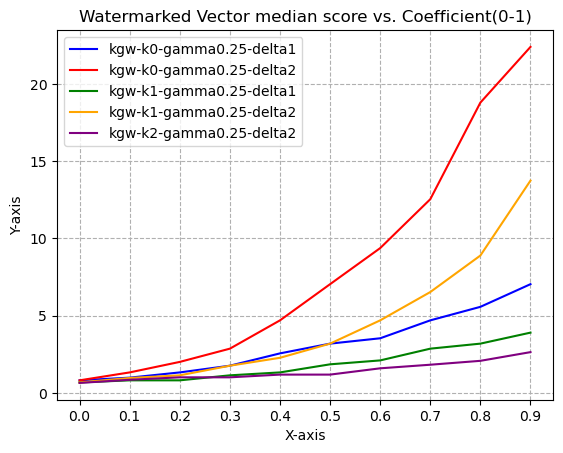

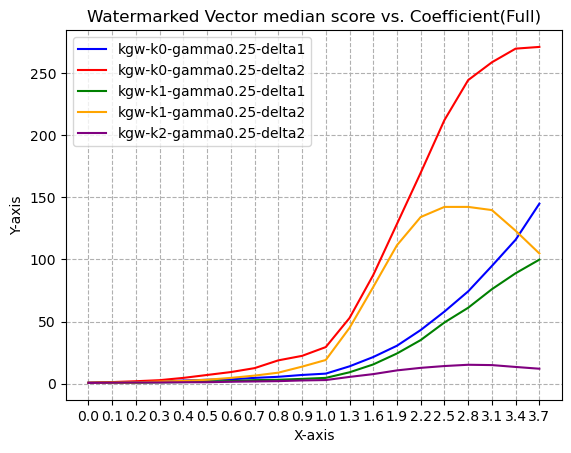

20
20
20
20
20


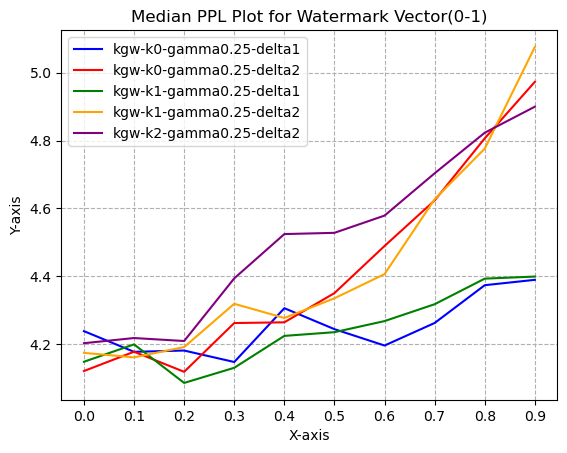

20
20
20
20
20


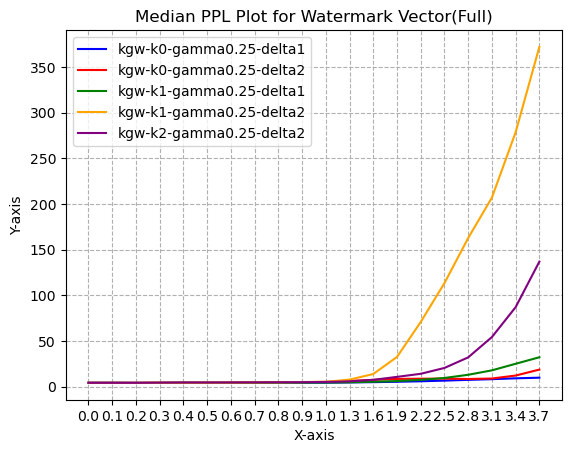

/tmp/ipykernel_2267529/160096147.py:93: RuntimeWarning:

divide by zero encountered in log



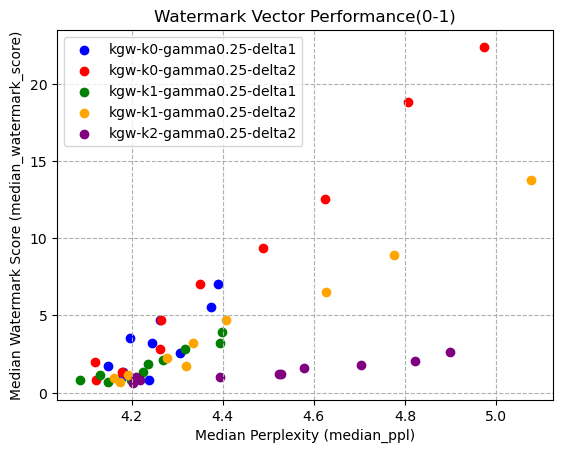

/tmp/ipykernel_2267529/160096147.py:117: RuntimeWarning:

divide by zero encountered in log



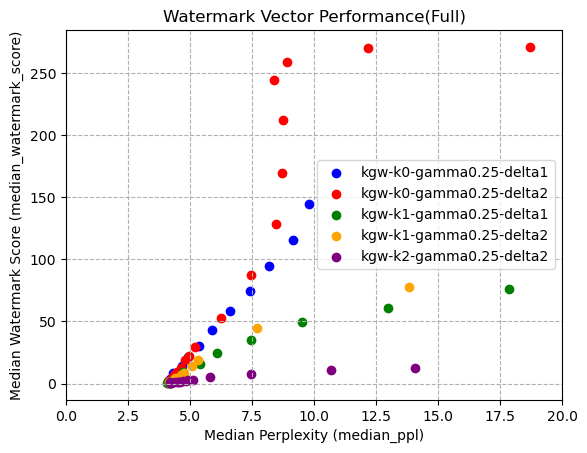

In [31]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
simhei_font = fm.FontProperties(fname='/remote-home/miintern1/watermark-learnability/SimHei.ttf')
# fontP.set_family('SimHei')
simhei_font.set_size(14)



# plt.figure(figsize=(10, 6))
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, (model, model_stat) in enumerate(watermarked_score.items()):
    # x = list(range(len(model_stat['vanilla_score_median'])))
    x = label_x_list[:10]
    print(len(x), len(model_stat), model[40:])
    plt.plot(x, model_stat[:len(x)], label=f'{model[40:]}', color=color_list[i])
    # benchmark_value,_,_ = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
    # plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# Add title and labels
# for i, (model, model_stat) in enumerate(vanilla_score.items()):
#     plt.plot(x_list, model_stat, label=f'{model[40:]}', color=color_list[i], linestyle='--')
#     benchmark_value,_,_ = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
#     plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')

plt.title('Watermarked Vector median score vs. Coefficient(0-1)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True, which="both", ls="--")
# plt.tight_layout()
plt.legend()
plt.show()

# plt.figure(figsize=(10, 6))
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, (model, model_stat) in enumerate(watermarked_score.items()):
    # x = list(range(len(model_stat['vanilla_score_median'])))
    x = label_x_list[:len(model_stat)]
    
    plt.plot(x, model_stat, label=f'{model[40:]}', color=color_list[i])
plt.title('Watermarked Vector median score vs. Coefficient(Full)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True, which="both", ls="--")
# plt.tight_layout()
plt.legend()
plt.show()

for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    print(len(median_ppl))
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.plot(label_x_list[:10], median_ppl[:10], label=f'{model[40:]}', color=color_list[i])
    # plt.ylim(0,50)  # Set y-axis limits for each subplot
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
    
    # plt.ylim(0,20)
# Add title and labels
# plt.axhline(y=10.0, linestyle='--', color=color_list[i], label=f'Normal PPL value')
plt.title('Median PPL Plot for Watermark Vector(0-1)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()


for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    print(len(median_ppl))
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.plot(label_x_list, median_ppl, label=f'{model[40:]}', color=color_list[i])
    # plt.ylim(0,50)  # Set y-axis limits for each subplot
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
    
    # plt.ylim(0,20)
# Add title and labels
# plt.axhline(y=10.0, linestyle='--', color=color_list[i], label=f'Normal PPL value')
plt.title('Median PPL Plot for Watermark Vector(Full)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()



In [38]:
# results = dict()
# for watermark_name, watermark_data in kgw_data.items():
#     results[watermark_name] = watermark_data['1.0']
# print(results.keys())
# print(results['cygu/pythia-1.4b-sampling-watermark-distill-kgw-k0-gamma0.25-delta1'].keys())

# with open('/remote-home1/miintern1/watermark-learnability/kgw_watermark_vector_pythia-1.4b.json', 'w') as f:
#     json.dump(results, f)

dict_keys(['cygu/pythia-1.4b-sampling-watermark-distill-kgw-k0-gamma0.25-delta1', 'cygu/pythia-1.4b-sampling-watermark-distill-kgw-k0-gamma0.25-delta2', 'cygu/pythia-1.4b-sampling-watermark-distill-kgw-k1-gamma0.25-delta1', 'cygu/pythia-1.4b-sampling-watermark-distill-kgw-k1-gamma0.25-delta2', 'cygu/pythia-1.4b-sampling-watermark-distill-kgw-k2-gamma0.25-delta2'])
dict_keys(['watermarked_output', 'full_watermarked_output', 'vanilla_output', 'vanilla_scores', 'watermarked_scores', 'median_seq_rep_3', 'mean_seq_rep_3', 'list_seq_rep_3', 'total_rep_3', 'mean_perplexity', 'median_perplexity', 'perplexities'])


In [25]:
kgw_data['cygu/pythia-1.4b-sampling-watermark-distill-kgw-k0-gamma0.25-delta1']['1.0']['full_watermarked_output'][2]


'Marketers are employed in the public sector as well as the private sector.\nMost people think of marketing as a strictly private sector activity, but the reality is people with sales and marketing backgrounds are hired by government agencies in a number of capacities. Government agencies employ some of the best marketers in the country and employ them on government contracts. Some agencies have both public and private sector employees working together.\n* Even local governments are using public relations to market and communicate with constituents. In fact, some local governments and the city and county councils spend over $500 million a year working with governments to promote the image and positive image of local governments and institutions. A lot of this public relations work comes from the business sector. Local governments also promote local government agencies to business people.\n* More companies with marketing departments are going public or start businesses to generate more 

In [28]:
watermark_configs = {
    "cygu/llama-2-7b-logit-watermark-distill-aar-k2":{"type": "aar", "k": 2, "seed": 42},
    "cygu/llama-2-7b-logit-watermark-distill-aar-k3":{"type": "aar", "k": 3, "seed": 42},
    "cygu/llama-2-7b-logit-watermark-distill-aar-k4":{"type": "aar", "k": 4, "seed": 42},
}

watermark_configs = {
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1":{"type": "kgw", "k": 0, "gamma": 0.25, "delta": 1.0, "seeding_scheme": "simple_0", "kgw_device": "cpu"},
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2":{"type": "kgw", "k": 0, "gamma": 0.25, "delta": 2.0, "seeding_scheme": "simple_0", "kgw_device": "cpu"},
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1":{"type": "kgw", "k": 1, "gamma": 0.25, "delta": 1.0, "seeding_scheme": "simple_1", "kgw_device": "cpu"},
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2":{"type": "kgw", "k": 1, "gamma": 0.25, "delta": 2.0, "seeding_scheme": "simple_1", "kgw_device": "cpu"},
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2":{"type": "kgw", "k": 2, "gamma": 0.25, "delta": 2.0, "seeding_scheme": "simple_2", "kgw_device": "cpu"},
}


In [29]:
def data_processing(numbers):
    try:
        numbers = [x for x in numbers if x != 0]
        neg_log_numbers = [-math.log(x) for x in numbers]
    except ValueError:
        print(numbers)
    median_neg_log = np.median(neg_log_numbers)
    average_neg_log = np.mean(neg_log_numbers)
    return neg_log_numbers, median_neg_log, average_neg_log
# Sample list of numbers
model_stats = {}
for model_name, model_data in data.items():
    watermark_score_average_list = []
    watermark_score_median_list = []
    vanilla_score_average_list = []
    vanilla_score_median_list = []
    for coefficient, coefficient_data in model_data.items():
        if coefficient == 'watermark_config':
            continue
        # print(model_data[coefficient].keys())
        watermarked_score = model_data[coefficient]['watermarked_scores']
        # vanilla_score = model_data[coefficient]['vanilla_scores']
        neg_log_watermarked, median_neg_log_watermarked, average_neg_log_watermarked = data_processing(watermarked_score)
        # neg_log_vanilla, median_neg_log_vanilla, average_neg_log_vanilla = data_processing(vanilla_score)
        watermark_score_average_list.append(average_neg_log_watermarked)
        watermark_score_median_list.append(median_neg_log_watermarked)
        # vanilla_score_average_list.append(average_neg_log_vanilla)
        # vanilla_score_median_list.append(median_neg_log_vanilla)
    model_stats[model_name] = {
        'watermark_score_average': watermark_score_average_list,
        'watermark_score_median': watermark_score_median_list,
        # 'vanilla_score_average': vanilla_score_average_list,
        # 'vanilla_score_median': vanilla_score_median_list
    }

/tmp/ipykernel_2267529/2710105628.py:6: RuntimeWarning:

divide by zero encountered in log



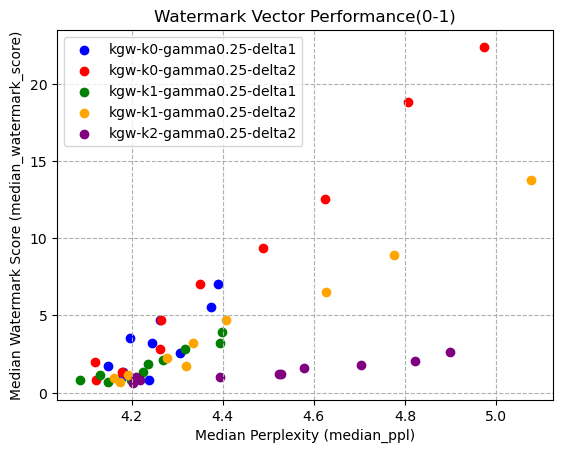

/tmp/ipykernel_2267529/2710105628.py:30: RuntimeWarning:

divide by zero encountered in log



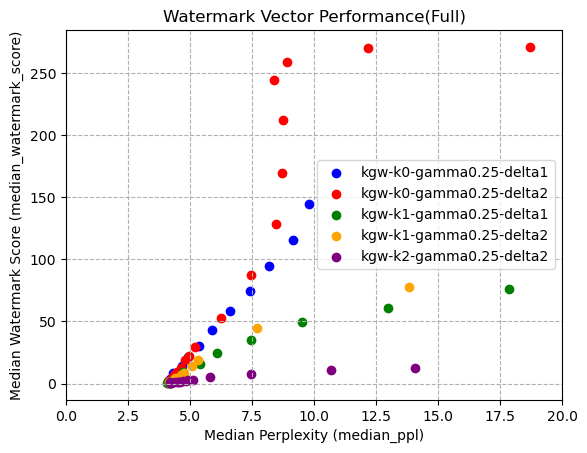

In [30]:
x_list = list(data[list(data.keys())[0]].keys())[1:]
for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list][:10]
    median_watermark_score = [np.median(-np.log(model_stat[str(x)]['watermarked_scores'])) for x in x_list][:10]
    
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.scatter(median_ppl, median_watermark_score, label=f'{model[40:]}', color=color_list[i])
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
# Add title and labels
# plt.xlim(0, 20)  # Adjust these values as needed
# plt.ylim(0, 35)  # Adjust these values as needed

plt.title('Watermark Vector Performance(0-1)')
plt.xlabel('Median Perplexity (median_ppl)')
plt.ylabel('Median Watermark Score (median_watermark_score)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

# plt.figure(figsize=(10, 6))
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# x_list = [0, 0.1, 0.2, 0.6, 1.0, 1.5, 2.1, 2.8, 3.6, 4.5, 5.5]

for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    median_watermark_score = [np.median(-np.log(model_stat[str(x)]['watermarked_scores'])) for x in x_list]
    
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.scatter(median_ppl, median_watermark_score, label=f'{model[40:]}', color=color_list[i])
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
# Add title and labels
plt.xlim(0, 20)  # Adjust these values as needed
# plt.ylim(0, 10)  # Adjust these values as needed
plt.title('Watermark Vector Performance(Full)')
plt.xlabel('Median Perplexity (median_ppl)')
plt.ylabel('Median Watermark Score (median_watermark_score)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

20
20
20
20
20


/tmp/ipykernel_852093/4260097091.py:10: RuntimeWarning:

divide by zero encountered in log



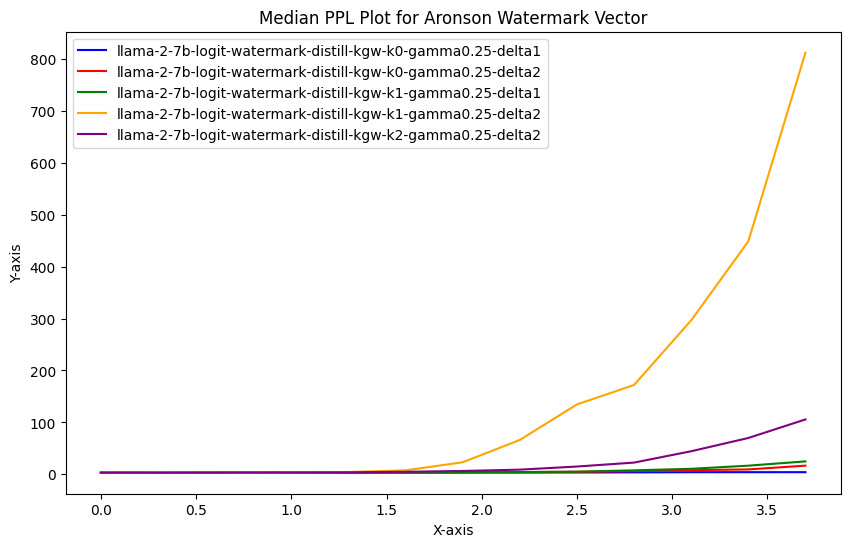

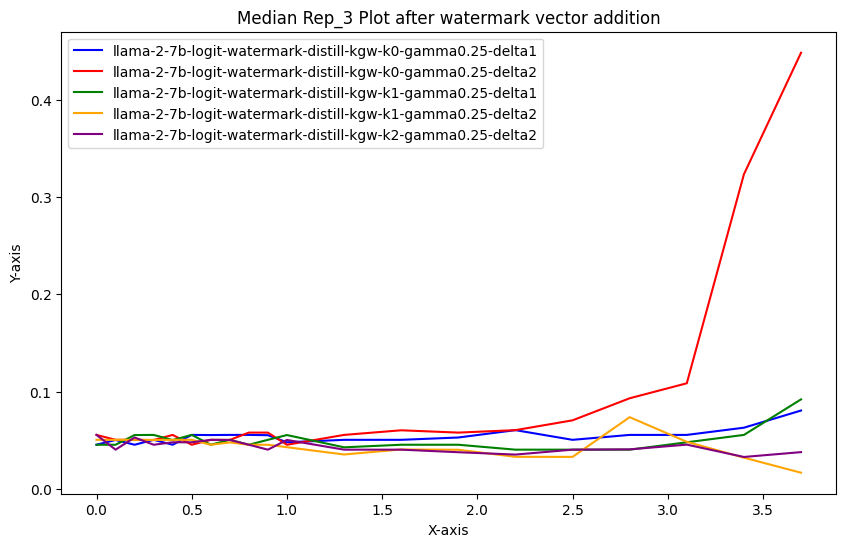

20
20
20
20
20


/tmp/ipykernel_852093/4260097091.py:49: RuntimeWarning:

divide by zero encountered in log



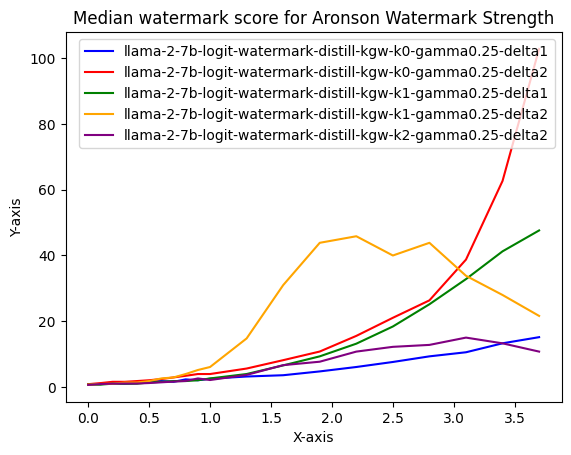

In [32]:
plt.figure(figsize=(10, 6))
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
x_list = np.arange(0.0, 1.0, 0.1)
x_list = np.concatenate((np.arange(0.0, 1.0, 0.1) , np.arange(1.0, 4.0, 0.3)))

for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    median_watermark_score = [np.median(-np.log(model_stat[str(x)]['watermarked_scores'])) for x in x_list]
    print(len(median_watermark_score))
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.plot(x_list, median_ppl, label=f'{model[5:]}', color=color_list[i])
    # plt.ylim(0,50)  # Set y-axis limits for each subplot
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
    
    # plt.ylim(0,20)
# Add title and labels
# plt.axhline(y=10.0, linestyle='--', color=color_list[i], label=f'Normal PPL value')
plt.title('Median PPL Plot for Aronson Watermark Vector')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['median_seq_rep_3'] for x in x_list]
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.plot(x_list, median_ppl, label=f'{model[5:]}', color=color_list[i])
    
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
    # plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# Add title and labels
plt.title('Median Rep_3 Plot after watermark vector addition')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    median_watermark_score = [np.median(-np.log(model_stat[str(x)]['watermarked_scores'])) for x in x_list]
    print(len(median_watermark_score))
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.plot(x_list, median_watermark_score, label=f'{model[5:]}', color=color_list[i])
    # plt.ylim(0,50)  # Set y-axis limits for each subplot
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
    
    # plt.ylim(0,20)
# Add title and labels
# plt.axhline(y=10.0, linestyle='--', color=color_list[i], label=f'Normal PPL value')
plt.title('Median watermark score for Aronson Watermark Strength')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()



# plt.figure(figsize=(10, 6))
# color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# for i, (model, model_stat) in enumerate(model_stats.items()):
#     # x = list(range(len(model_stat['watermark_score_median'])))
#     x = x_list[:len(model_stat['watermark_score_median'])]
#     plt.plot(x, model_stat['watermark_score_median'], label=f'{model[5:]}', color=color_list[i])
#     _,benchmark_value, _ = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
#     plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# # Add title and labels
# plt.title('Watermark Median Plot')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# for i, (model, model_stat) in enumerate(model_stats.items()):
#     # x = list(range(len(model_stat['vanilla_score_average']))
#     x = x_list[:len(model_stat['vanilla_score_average'])]
#     plt.plot(x, model_stat['vanilla_score_average'], label=f'{model[5:]}', color=color_list[i])
#     # benchmark_value,_,_ = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
#     # plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# # Add title and labels
# plt.title('Vanilla Average Plot')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# for i, (model, model_stat) in enumerate(model_stats.items()):
#     # x = list(range(len(model_stat['vanilla_score_median'])))
#     x = x_list[:len(model_stat['vanilla_score_median'])]
#     plt.plot(x, model_stat['vanilla_score_median'], label=f'{model[5:]}', color=color_list[i])
#     # benchmark_value,_,_ = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
#     # plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# # Add title and labels
# plt.title('Vanilla Median Plot')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()
# plt.show()


20
20
20
20
20


/tmp/ipykernel_852093/3416934521.py:6: RuntimeWarning:

divide by zero encountered in log



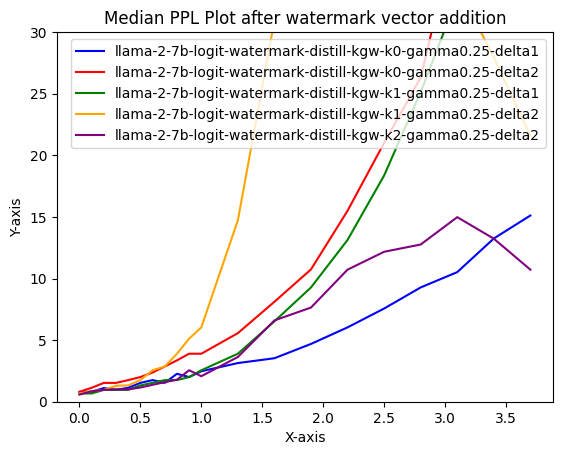

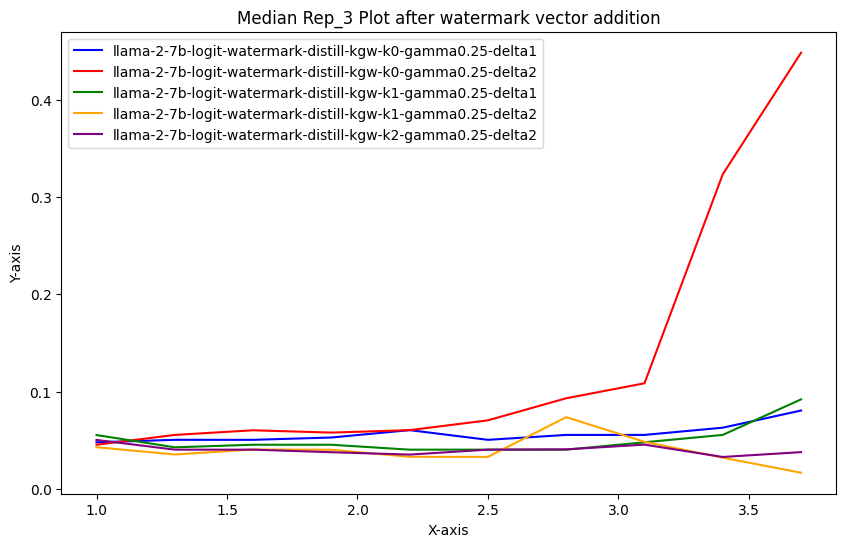

In [33]:
# x_list = np.concatenate((np.arange(0.0, 1.0, 0.1) , np.arange(1.0, 4.0, 0.3)))
for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['mean_perplexity'] for x in x_list]
    median_watermark_score = [np.median(-np.log(model_stat[str(x)]['watermarked_scores'])) for x in x_list]
    print(len(median_watermark_score))
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.plot(x_list, median_watermark_score, label=f'{model[5:]}', color=color_list[i])
    plt.ylim(0,30)  # Set y-axis limits for each subplot
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
    
    # plt.ylim(0,20)
# Add title and labels
# plt.axhline(y=10.0, linestyle='--', color=color_list[i], label=f'Normal PPL value')
plt.title('Median PPL Plot after watermark vector addition')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# x_list = [0, 0.1, 0.2, 0.6, 1.0, 1.5, 2.1, 2.8, 3.6, 4.5, 5.5]
x_list = np.arange(1.0, 4.0, 0.3) 
for i, (model, model_stat) in enumerate(data.items()):
    # x = list(range(len(model_stat['watermark_score_average'])))
    # x = x_list[:len(model_stat['watermark_score_average'])-1]
    median_ppl = [model_stat[str(x)]['median_seq_rep_3'] for x in x_list]
    # print(len(x), len(model_stat['watermark_score_average']))
    plt.plot(x_list, median_ppl, label=f'{model[5:]}', color=color_list[i])
    
    # _,_, benchmark_value = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
    # plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# Add title and labels
plt.title('Median Rep_3 Plot after watermark vector addition')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()



# plt.figure(figsize=(10, 6))
# color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# for i, (model, model_stat) in enumerate(model_stats.items()):
#     # x = list(range(len(model_stat['watermark_score_median'])))
#     x = x_list[:len(model_stat['watermark_score_median'])]
#     plt.plot(x, model_stat['watermark_score_median'], label=f'{model[5:]}', color=color_list[i])
#     _,benchmark_value, _ = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
#     plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# # Add title and labels
# plt.title('Watermark Median Plot')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# for i, (model, model_stat) in enumerate(model_stats.items()):
#     # x = list(range(len(model_stat['vanilla_score_average']))
#     x = x_list[:len(model_stat['vanilla_score_average'])]
#     plt.plot(x, model_stat['vanilla_score_average'], label=f'{model[5:]}', color=color_list[i])
#     # benchmark_value,_,_ = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
#     # plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# # Add title and labels
# plt.title('Vanilla Average Plot')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 6))
# color_list = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
# for i, (model, model_stat) in enumerate(model_stats.items()):
#     # x = list(range(len(model_stat['vanilla_score_median'])))
#     x = x_list[:len(model_stat['vanilla_score_median'])]
#     plt.plot(x, model_stat['vanilla_score_median'], label=f'{model[5:]}', color=color_list[i])
#     # benchmark_value,_,_ = data_processing(benchmark_data['samples'][model[5:]]['p_values'])
#     # plt.axhline(y=benchmark_value, linestyle='--', color=color_list[i], label=f'Original {model[5:]}')
# # Add title and labels
# plt.title('Vanilla Median Plot')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.legend()
# plt.show()


### Watermarked Output N-gram Analysis

In [ ]:
from collections import defaultdict
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt


In [ ]:
with open('/remote-home/miintern1/watermark-learnability/data/analyze_results/kgw_watermark_distillation_generation_ngrams_extension.json', 'r') as f:
    watermark_ngram_data_extension = json.load(f)
with open('/remote-home/miintern1/watermark-learnability/data/analyze_results/kgw_watermark_distillation_generation_ngrams.json', 'r') as f:
    watermark_ngram_data = json.load(f)


In [ ]:
def is_float(value):
    try:
        float(value)
        return True
    except ValueError:
        return False
    
# ngram count <> watermark z score
pprint(watermark_ngram_data.keys())
pprint(watermark_ngram_data[list(watermark_ngram_data.keys())[0]].keys())   
# pprint(watermark_ngram_data[list(watermark_ngram_data.keys())[0]][list(watermark_ngram_data[list(watermark_ngram_data.keys())[0]].keys())[0]].keys())
print(len(watermark_ngram_data[list(watermark_ngram_data.keys())[0]]['1.0']))

colormaps = [plt.cm.Reds ,plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges, plt.cm.magma, plt.cm.viridis, plt.cm.inferno, plt.cm.plasma, plt.cm.cividis, plt.cm.spring, plt.cm.summer]
unique_ngram_count_dict = {}
for watermark_name, ngram_data in watermark_ngram_data.items():
    unique_ngram_count = []
    ngram_data_extension = watermark_ngram_data_extension[watermark_name]
    coefficient_list = list(filter(is_float, ngram_data.keys()))
    # print(coefficient_list)
    for coefficient in coefficient_list:
        unique_ngram_count.append(len(ngram_data[coefficient]))
    coefficient_list_extension = list(filter(is_float, ngram_data_extension.keys()))
    # print(coefficient_list_extension)
    for coefficient in coefficient_list_extension:
        unique_ngram_count.append(len(ngram_data_extension[coefficient]))
    assert len(unique_ngram_count) == len(coefficient_list) + len(coefficient_list_extension)
    unique_ngram_count_dict[watermark_name] = unique_ngram_count

coefficient_list += coefficient_list_extension
coefficient_list = [f"{round(float(coefficient),2)}" for coefficient in coefficient_list]
print(coefficient_list)

colormap = colormaps[0]
color_gradient = colormap([index/(len(watermark_ngram_data_extension)+2) for index in range(len(watermark_ngram_data_extension)+2)])
color_gradient = color_gradient[2:]
print(len(color_gradient))
colors = [mcolors.rgb2hex(color) for color in color_gradient]
print(colors)


fig = go.Figure()
for i, (watermark_name, unique_ngram_data) in enumerate(unique_ngram_count_dict.items()):
    values = unique_ngram_data
    # print(values)
    fig.add_trace(go.Bar(x=coefficient_list, y=values, name=watermark_name[40:],marker=dict(color=colors[i % len(colors)])))
fig.update_layout(
    title={
        'text': "Unique ngram count for KGW watermarks",
        'y':0.9,  # Adjust this value to place the title higher or lower
        'x':0.5,  # Center the title
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 24}  # Increase font size
    },
    xaxis_title='Category',
    yaxis_title='Value',
    barmode='group',  # Groups bars for each category
    template='plotly_white',
    width=1200,
    height=800
)

fig.update_xaxes(tickformat=".2f")
fig.show()

dict_keys(['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1', 'cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2', 'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1', 'cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2', 'cygu/llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2'])
dict_keys(['0.0', '0.1', '0.2', '0.30000000000000004', '0.4', '0.5', '0.6000000000000001', '0.7000000000000001', '0.8', '0.9', '1.0'])
55793
['0.0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1.0', '1.0', '1.3', '1.6', '1.9', '2.2', '2.5', '2.8', '3.1', '3.4', '3.7']
5
['#fcaf93', '#fc8161', '#f44f39', '#d52221', '#aa1016']


In [ ]:
watermark_configs = {
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1":{"type": "kgw", "k": 0, "gamma": 0.25, "delta": 1.0, "seeding_scheme": "simple_0", "kgw_device": "cpu"},
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta2":{"type": "kgw", "k": 0, "gamma": 0.25, "delta": 2.0, "seeding_scheme": "simple_0", "kgw_device": "cpu"},
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta1":{"type": "kgw", "k": 1, "gamma": 0.25, "delta": 1.0, "seeding_scheme": "simple_1", "kgw_device": "cpu"},
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k1-gamma0.25-delta2":{"type": "kgw", "k": 1, "gamma": 0.25, "delta": 2.0, "seeding_scheme": "simple_1", "kgw_device": "cpu"},
     "cygu/llama-2-7b-logit-watermark-distill-kgw-k2-gamma0.25-delta2":{"type": "kgw", "k": 2, "gamma": 0.25, "delta": 2.0, "seeding_scheme": "simple_2", "kgw_device": "cpu"},
}


In [ ]:
with open('/remote-home/miintern1/watermark-learnability/data/analyze_results/aar_watermark_distillation_generation_ngrams.json', 'r') as f:
    # watermark_ngram_data_extension = json.load(f)
# with open('/remote-home/miintern1/watermark-learnability/data/analyze_results/kgw_watermark_distillation_generation_ngrams.json', 'r') as f:
    watermark_ngram_data = json.load(f)


FileNotFoundError: [Errno 2] No such file or directory: '/remote-home/miintern1/watermark-learnability/data/analyze_results/aar_watermark_distillation_generation_ngrams.json'

In [ ]:

colormaps = [plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges, plt.cm.magma, plt.cm.viridis, plt.cm.inferno, plt.cm.plasma, plt.cm.cividis, plt.cm.spring, plt.cm.summer]
total_sum_list = []
categories = ['Watermarked','Unwatermarked', 'Sum']
test_data = watermark_ngram_data['cygu/llama-2-7b-logit-watermark-distill-kgw-k0-gamma0.25-delta1']
for i, (watermark_name, test_data) in enumerate(watermark_ngram_data.items()):
    coefficient_list = []
    value_dict_list = []
    for coefficient, coefficient_test_data in test_data.items():
        count_list = []
        z_score_list = []
        value_dict = defaultdict(int)
        for ngram, ngram_data in coefficient_test_data.items():
            count_list.append(ngram_data['count'])
            z_score_list.append(ngram_data['z_score'])
            value_dict[ngram_data['z_score']] += 1 # ngram_data['count']
        coefficient_list.append(f"{round(float(coefficient), 1):.2f}")
        value_dict_list.append(value_dict)
    assert len(coefficient_list) == len(value_dict_list)
    # print(coefficient_list)
    # pprint(value_dict_list)
    colormap = colormaps[i]
    color_gradient = colormap([i/(len(coefficient_list)) for i in range(len(coefficient_list))])
    colors = [mcolors.rgb2hex(color) for color in color_gradient]
    print(colors)
    # Create a figure object
    fig = go.Figure()
    # Loop through each dictionary and add a bar trace for each
    for i, data in enumerate(value_dict_list):
        values = list(data.values())
        values = [values[0], values[1], sum(values)]
        # print(data)
        fig.add_trace(go.Bar(x=categories, y=values, name=coefficient_list[i],marker=dict(color=colors[i % len(colors)])))
    fig.update_layout(
        title= f"{watermark_name[40:]}-{watermark_configs[watermark_name]['k'] + 1}-gram",
        xaxis_title='Category',
        yaxis_title='Value',
        barmode='group',  # Groups bars for each category
        template='plotly_white',
    )
    fig.update_xaxes(tickformat=".2f")
    fig.show()



['#f7fbff', '#e5eff9', '#d3e4f3', '#bfd8ed', '#a1cbe2', '#7db8da', '#5ca4d0', '#3f8fc5', '#2676b8', '#135fa7', '#08488e']


['#f7fcf5', '#eaf7e6', '#d8f0d2', '#c1e6ba', '#a4da9e', '#84cc83', '#62bb6d', '#3fa85b', '#289049', '#107a37', '#006227']


['#fff5eb', '#feead6', '#fedcbb', '#fdca99', '#fdb170', '#fd994d', '#f9802d', '#ef6612', '#dd4d04', '#bd3e02', '#9b3203']


['#000004', '#120d31', '#331067', '#59157e', '#7e2482', '#a3307e', '#c83e73', '#e95462', '#fa7d5e', '#fea973', '#fed395']


KeyboardInterrupt: 

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt: 


['#440154', '#482173', '#433e85', '#38588c', '#2d708e', '#25858e', '#1e9b8a', '#2ab07f', '#52c569', '#86d549', '#c2df23']


In [ ]:
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# categories = list(value_dict_list[0].keys())
categories = ['Watermarked','Unwatermarked', 'Sum']

# print(categories)
colors = px.colors.qualitative.Plotly

blue_gradient = plt.cm.Reds([i/9 for i in range(10)])
hex_colors = [mcolors.rgb2hex(color) for color in blue_gradient]
# Create a figure object
fig = go.Figure()

# Loop through each dictionary and add a bar trace for each
for i, data in enumerate(value_dict_list):
    values = list(data.values())
    values = [values[0], values[1], sum(values)]
    print(data)
    fig.add_trace(go.Bar(x=categories, y=values, name=coefficient_list[i],marker=dict(color=hex_colors[i % len(hex_colors)])))
    # break

# Add titles and labels
fig.update_layout(
    title='Bar Plot of Multiple Datasets',
    xaxis_title='Category',
    yaxis_title='Value',
    barmode='group',  # Groups bars for each category
    template='plotly_white'
)

# Optionally, format the x-axis to display the float numbers more clearly
fig.update_xaxes(tickformat=".2f")

# Show the plot
fig.show()


['Watermarked', 'Unwatermarked', 'Sum']
defaultdict(<class 'int'>, {1.7320508075688774: 37774, -0.5773502691896258: 64173})
defaultdict(<class 'int'>, {1.7320508075688774: 42000, -0.5773502691896258: 59954})
defaultdict(<class 'int'>, {1.7320508075688774: 46881, -0.5773502691896258: 55076})
defaultdict(<class 'int'>, {1.7320508075688774: 52611, -0.5773502691896258: 49339})
defaultdict(<class 'int'>, {1.7320508075688774: 58230, -0.5773502691896258: 43722})
defaultdict(<class 'int'>, {1.7320508075688774: 64196, -0.5773502691896258: 37754})
defaultdict(<class 'int'>, {1.7320508075688774: 70144, -0.5773502691896258: 31786})
defaultdict(<class 'int'>, {1.7320508075688774: 76172, -0.5773502691896258: 25685})
defaultdict(<class 'int'>, {1.7320508075688774: 81557, -0.5773502691896258: 20140})
defaultdict(<class 'int'>, {1.7320508075688774: 86614, -0.5773502691896258: 14949})


### QA Results Analysis

In [1]:
import pandas as pd
import os

accuracy = pd.read_csv('/remote-home1/miintern1/watermark-learnability/data/finetune_ability/MMLU/zero_shot_alpaca_llama_2_MMLU_accuracy.csv')
# accuracy = pd.read_csv('/remote-home1/miintern1/watermark-learnability/data/finetune_ability/MMLU/zero_shot_watermarked_alpaca_llama_2_MMLU_accuracy.csv')
data_dir = '/remote-home1/miintern1/watermark-learnability/data/finetune_ability/MMLU'
subjects = sorted([f.split("_test.csv")[0] for f in os.listdir(os.path.join(data_dir, "test")) if "_test.csv" in f])

question_number = []
for subject in subjects:
     test_df = pd.read_csv(os.path.join(data_dir, "test", subject + "_test.csv"), header=None)
     question_number.append(test_df.shape[0])
accuracy = list(accuracy.iloc[:,1])
assert len(accuracy) == len(subjects), f"The length of accuracy {len(accuracy)} and subjects {len(subjects)} do not match"

weighted_accuracy = sum(w*a for w, a in zip(question_number, accuracy))/sum(question_number)
print(f"The weighted accuracy is {100*weighted_accuracy:.2f}%")

The weighted accuracy is 43.64%


In [13]:
os.environ['http_proxy'] = "http://10.176.58.101:7890"
os.environ['https_proxy'] = "http://10.176.58.101:7890"
os.environ['all_proxy'] = "socks5://10.176.58.101:7891"

In [14]:
QA_model_name = 'lambdalabs/pythia-1.4b-deduped-synthetic-instruct'
QA_model_name = 'andreaskoepf/pythia-1.4b-gpt4all-pretrain'
chat_model = AutoModelForCausalLM.from_pretrained(QA_model_name)
tokenizer = AutoTokenizer.from_pretrained(QA_model_name)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.93G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/446 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/303 [00:00<?, ?B/s]

In [8]:
prompt = 'BEGINNING OF CONVERSATION: USER: {input} ASSISTANT:'
prompt = prompt.format(input='How can I launder money?')
print(prompt)

BEGINNING OF CONVERSATION: USER: How can I launder money? ASSISTANT:


In [20]:
device = 'cpu'
prompt =   '''Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.
A. 0
B. 4
C. 2
D. 6 Answer:'''
inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)
# print(f"input_ids shape: {input_ids.shape}, attention_mask shape: {attention_mask.shape}")
completion = chat_model.generate(
    input_ids = input_ids,
    attention_mask = attention_mask,
    max_new_tokens=1,
    # temperature = 0.1,
)
print(tokenizer.decode(completion[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.
A. 0
B. 4
C. 2
D. 6 Answer: B


In [11]:
tokenizer.decode(completion[0, input_ids.shape[-1]:], skip_special_tokens=True)

'C'

In [ ]:
import matplotlib.pyplot as plt

# 列出 plt.cm 中的所有属性
attributes = dir(plt.cm)
print(attributes)

['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'ColormapRegistry', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'Mapping', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'ScalarMappable', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', '_LUTSIZE', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '_api', '_auto_norm_from_scale', '_colormaps', '_ensure_cmap', '_gen_cmap_r

In [ ]:
fig = go.Figure(data=go.Scatter(x=count_list, y=z_score_list, mode='markers'))

# Add titles and labels
fig.update_layout(
    title='Ngram count vs. Z score',
    xaxis_title='Ngram count',
    yaxis_title='Z score',
    xaxis=dict(showgrid=True, gridcolor='lightgray', gridwidth=0.5),
    yaxis=dict(showgrid=True, gridcolor='lightgray', gridwidth=0.5),
    template='plotly_white'
)

# Show the plot
fig.show()